<div style="border-top: 3px solid #0a6d91; padding: 15px; display: flex; align-items: center; justify-content: space-between;">

  <!-- Left text -->
  <div style="flex: 1; padding-right: 20px;">
    <h1 style= display: inline-block; padding: 5px 10px; border-radius: 3px;">
      Mutual Information Dynamics <br> in VAEs
    </h1>
    <h3>Information theory and inference</h3>
  </div>

  <!-- Right images -->
  <div style="flex: 0 0 auto; display: flex; align-items: center; gap: 20px;">
    <img src="https://th.bing.com/th/id/R.f158dd00f7e0e326ff081cf1acb39901?rik=tfJW%2frH3keCJ%2fg&riu=http%3a%2f%2fboostlab.dfa.unipd.it%2fimg%2flogo_pod.png&ehk=Th6GDiUuQTgD%2faBhIK7JUi15%2bG%2f35LzMJV9PFEPd9rg%3d&risl=&pid=ImgRaw&r=0" alt="PoD" width="250"/>
    <img src="https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova-1024x463.png" alt="UNIPD" width = "350" />
  </div>

</div>
<div style="border-bottom: 1px solid #0a6d91">
  <p><strong>Authors</strong></p>
  <table style="border-collapse: collapse; display: inline-table;">
    <tr>
      <td style="padding: 1px;">Boscolo Marco</td>
      <td style="padding: 1px;">2157559</td>
    </tr>
    <tr>
      <td style="padding: 1px;">La Rovere Francesco</td>
      <td style="padding: 1px;">2164968</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Montagner Nicolò</td>
      <td style="padding: 1px;">2165809</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Sabatini Raffaele</td>
      <td style="padding: 1px;">2165739</td>
    </tr>
  </table>
</div>

In [1]:
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
from VariationalModel import *
from Functions import *
from Classes import *

In [3]:
generate_index(file="Restyle.ipynb")


<h1 style="color:black; font-size: 38px; font-weight: 700; margin-bottom: 5px;">
    Index
</h1>

<hr style="border: 1px solid #000;">

<p style="font-size: 18px; color:black; margin-top: 10px;">

</p>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#Introduction" style="color:black; text-decoration:none;">Introduction</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Theoretical-Background" style="color:black; text-decoration:none;">Theoretical Background</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#General-Parameters-Setup" style="color:black; text-decoration:none;">General Parameters Setup</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Dataset-Description" style="color:black; text-decoration:none;">Dataset Description</a></span><br>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#RESTYLEEEE" style="color:black; text-decoration:none;">RESTYLEEEE</a></span><br>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#RESTYLE-COMPLETO-CON-NICK--FRANCESCO" style="color:black; text-decoration:none;">RESTYLE COMPLETO? CON NICK + FRANCESCO?</a></span><br>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#First-VAE-model" style="color:black; text-decoration:none;">First VAE model</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Set-up-model" style="color:black; text-decoration:none;">Set up model</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Training-Model" style="color:black; text-decoration:none;">Training Model</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#VAE-outputs" style="color:black; text-decoration:none;">VAE outputs</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Distributions-of-activations" style="color:black; text-decoration:none;">Distributions of activations</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Information-Plane" style="color:black; text-decoration:none;">Information Plane</a></span><br>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#Studying-tanh-activation" style="color:black; text-decoration:none;">Studying $\tanh$ activation</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Checking-the-SAXE-paper-about-linearity-and-non-linearity" style="color:black; text-decoration:none;">Checking the SAXE paper about linearity and non-linearity</a></span><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:17px; color:black; font-weight:500;">◦ <a href="#Changing-architecture-and-latent-space-dimension" style="color:black; text-decoration:none;">Changing architecture and latent space dimension</a></span><br>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#Studying-ReLU-activation" style="color:black; text-decoration:none;">Studying $ReLU$ activation</a></span><br>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#Parte-Nicol" style="color:black; text-decoration:none;">Parte Nicolò</a></span><br>
<span style="font-size:20px; color:black; font-weight:700;">• <a href="#Francesco-ridurre-info-dei-float" style="color:black; text-decoration:none;">Francesco ridurre info dei float</a></span><br>
<br>
<hr style="border: 1px solid #000;">
<br>


--------
--------

# Introduction

## Theoretical Background  

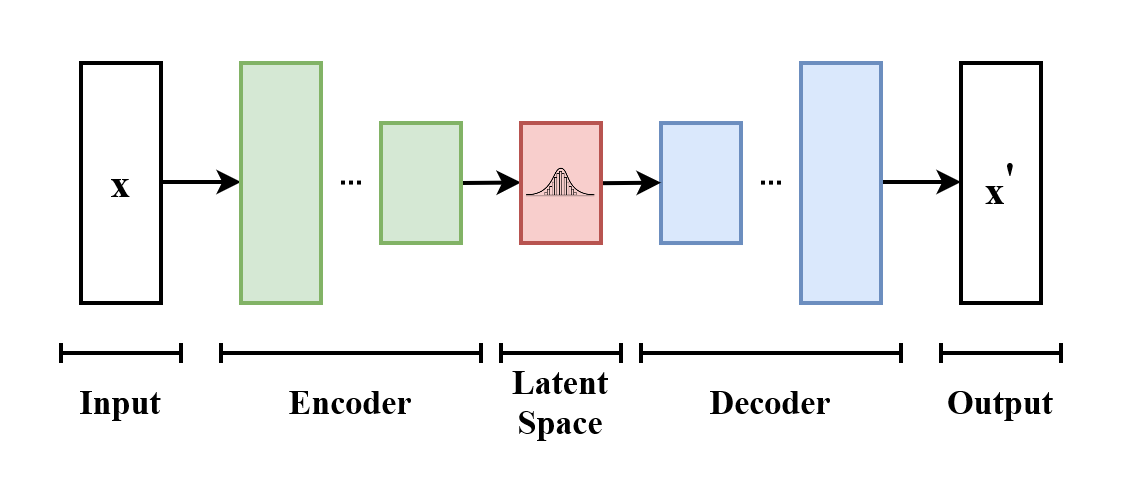

In [4]:
Image(filename="Images/VAE_Basic.png", width=600, height=500)

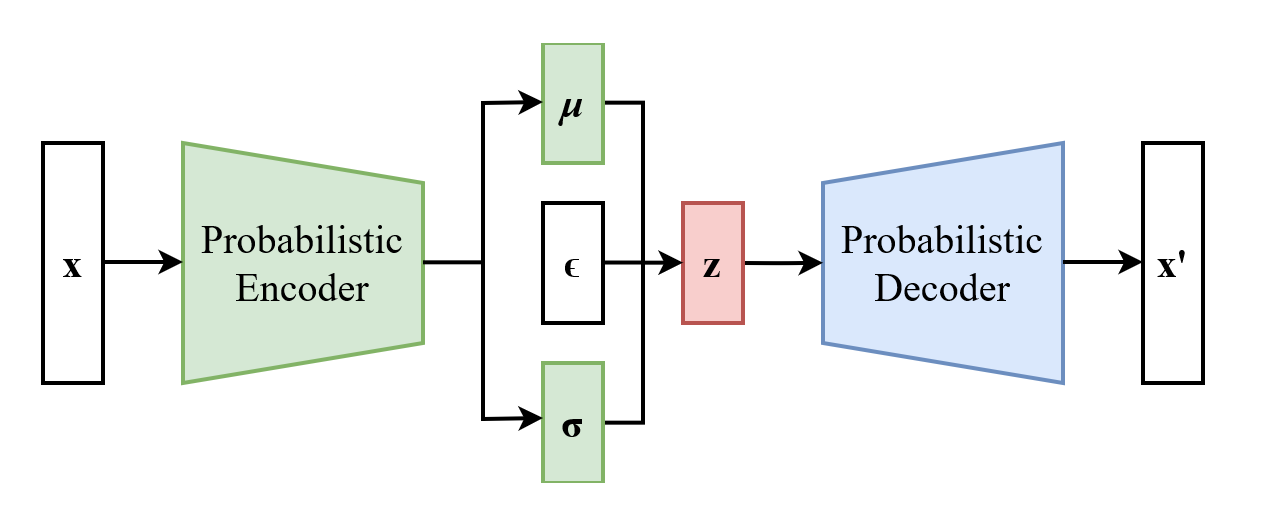

In [5]:
Image(filename="Images/Reparameterized_Variational_Autoencoder.png", width=600, height=500)

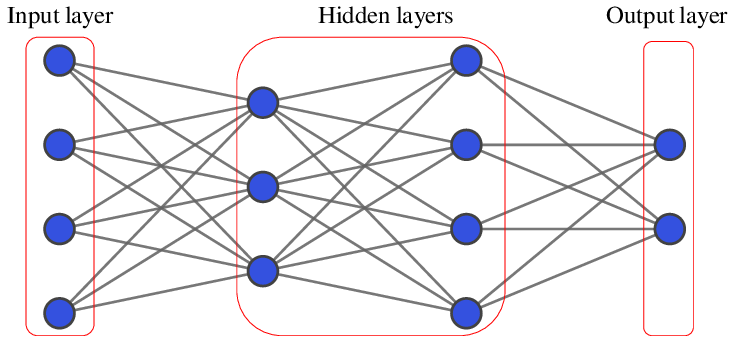

In [6]:
Image(filename="Images/FFNN.png", width=500, height=400)

## General Parameters Setup

In [7]:
binarize   = False
batch_size = 250

## Dataset Description

In [8]:
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

Selected device: cuda


In [9]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)
print(f"Length of the train dataset: {len(trainDataset)}")
print(f"Length of the test dataset: {len(testDataset)}")

Length of the train dataset: 60000
Length of the test dataset: 10000


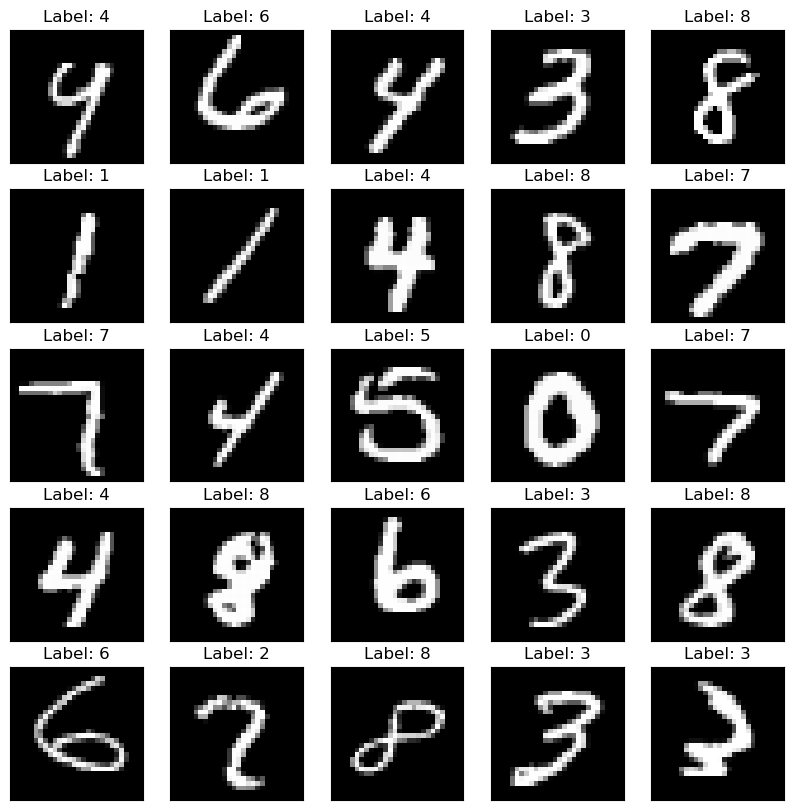

In [10]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [11]:
#Transforms in pytorch tensors
operations = [transforms.ToTensor()]
if binarize:
    operations.append( transforms.Lambda(lambda x: (x > 0.5).float()) )

final_transform = transforms.Compose(operations)
trainDataset.transform = final_transform
testDataset.transform  = final_transform

In [12]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([250, 1, 28, 28])
	 Labels: torch.Size([250])
TEST BATCH SHAPE
	 Data: torch.Size([250, 1, 28, 28])
	 Labels: torch.Size([250])


--------
--------

# RESTYLEEEE

In [13]:
from dataclasses import dataclass, field
from typing import Dict, Any, List
import torch
import torch.optim as optim


@dataclass
class ExperimentConfig:
    # Nome dato all'esperimento
    name: str
    # Parametri esatti per VariationalAutoEncoder.__init__
    model_params: Dict[str, Any]      
    # Parametri per il training (learning rate, epochs, batch_size)
    train_params: Dict[str, Any]      
    # Parametri per MI_Estimator (method, sigma, n_neig)
    mi_params: Dict[str, Any]

In [14]:
class VAEFramedTrainer:
    def __init__(self, train_loader, test_loader, device):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

    def loss_function(self, x, x_hat, mean, logVar):
        # Reconstruction Loss (Binary Cross Entropy)
        # Assicuriamoci che target e input abbiano la stessa shape
        reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        
        # KL Divergence
        KLD = -0.5 * torch.sum(1 + logVar - mean.pow(2) - logVar.exp())

        return reproduction_loss + KLD

    def run(self, config: ExperimentConfig):
        print(f"\n{'='*10} Avvio Esperimento: {config.name} {'='*10}")
        
        # --- 1. SETUP ---
        model = VariationalAutoEncoder(**config.model_params).to(self.device)
        
        lr = config.train_params.get("lr", 1e-3)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Recorder (Reset ad ogni esperimento)
        RecorderActivat = ActivationRecorder()
        RecorderActivat.InitialRegister(model)
        
        # MI Estimator & History
        mi_estimator = MI_Estimator(
            method=config.mi_params.get("method", "kmeans"),
            sigma=config.mi_params.get("sigma", 1.0),
            n_neig=config.mi_params.get("n_neig", 3)
        )
        mi_history = MI_History()
        
        # --- 2. TRAINING LOOP ---
        epochs = config.train_params.get("epochs", 20)
        model.train()
        
        for epoch in range(1, epochs + 1):
            train_loss = 0
            
            for batch_idx, (data, _) in enumerate(self.train_loader):
                # Flatten [Batch, 1, 28, 28] -> [Batch, 784]
                data = data.to(self.device).view(data.size(0), -1) 
                
                optimizer.zero_grad()
                
                x_hat, z, mean, logVar = model(data)
                
                loss = self.loss_function(data, x_hat, mean, logVar)
                
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
            
            avg_loss = train_loss / len(self.train_loader.dataset)
            print(f"[{config.name}] Epoch {epoch}/{epochs} \t Loss: {avg_loss:.4f}")

            # --- 3. ANALISI & LOGGING (MI) ---
            if "VAE_info" in globals():
                 # >>> CORREZIONE QUI: Catturiamo l'output e salviamo nella history <<<
                 mi_data = VAE_info(
                     model=model, 
                     dataset=self.test_loader.dataset, # Passiamo il dataset, non il loader
                     device=self.device, 
                     epoch=epoch, 
                     num_samples=1000, 
                     mi_estimator=mi_estimator, 
                     RecorderActivat=RecorderActivat
                 )
                 
                 # Salviamo i dati calcolati nella history dell'esperimento corrente
                 if mi_data is not None:
                     mi_history.append(mi_data)

        print(f"{'='*10} Fine Esperimento: {config.name} {'='*10}\n")
        
        return {
            "config": config,
            "model": model,
            "optimizer": optimizer,
            "recorder": RecorderActivat,
            "mi_estimator": mi_estimator,
            "mi_history": mi_history, # Ora conterrà i dati
            "final_loss": avg_loss
        }

In [ ]:
trainer = VAEFramedTrainer(trainDataloader, testDataloader, device)


# CASO A: Modello "Small" con metodo Kraskov
ExperimentConfig(
    name="Exp_Small_Kraskov",
    model_params={
        "inputDim": 784,
        "hiddenDim": [400,300],      # Architettura specifica
        "latentDim": 50,
        "temperature": 1.0
    },

    train_params={
        "lr": 1e-3, 
        "epochs": 2
    },
    mi_params={
        "method": "kde",       # Metodo MI
        "sigma": 2,               #
        "n_neig": 2,               # Parametro Kraskov
    }
)

In [29]:
# 1. Inizializza il Trainer (una volta sola)
trainer = VAEFramedTrainer(trainDataloader, testDataloader, device)

# 2. Definisci gli esperimenti (Configurazione Parametrica)
experiments_list = [
    # CASO A: Modello "Small" con metodo Kraskov
    ExperimentConfig(
        name="Exp_Small_Kraskov",
        model_params={
            "inputDim": 784,
            "hiddenDim": [400,300],      # Architettura specifica
            "latentDim": 50,
            "temperature": 1.0
        },
    
        train_params={
            "lr": 1e-3, 
            "epochs": 2
        },
        mi_params={
            "method": "kde",       # Metodo MI
            "sigma": 2,               #
            "n_neig": 2,               # Parametro Kraskov
        }
    ),
    
    # CASO B: Modello "Deep" con metodo KDE
    ExperimentConfig(
        name="Exp_Deep_KDE",
        model_params={
            "inputDim": 784,
            "hiddenDim": [512, 256],      # Architettura specifica
            "latentDim": 50,
            "temperature": 1.0
        },
        train_params={
            "lr": 5e-4, 
            "epochs": 2
        },
        mi_params={
            "method": "kde",           # Metodo MI
            "sigma": 0.2,              # Parametro KDE
            "n_neig": 3                # Parametro ininfluente qui
        }
    )
]

# 3. Esecuzione Batch
results = {}
for exp in experiments_list:
    # Il metodo .run() crea tutto da zero (model, recorder, mi_estimator)
    results[exp.name] = trainer.run(exp)

# 4. Accesso ai risultati
# Esempio: prendere il recorder dell'esperimento Deep
# my_recorder = results["Exp_Deep_KDE"]["recorder"]


========== Avvio Esperimento: Exp_Small_Kraskov ==========
[Exp_Small_Kraskov] Epoch 1/3 	 Loss: 203.4290
[Exp_Small_Kraskov] Epoch 2/3 	 Loss: 152.7255
[Exp_Small_Kraskov] Epoch 3/3 	 Loss: 132.8207
========== Fine Esperimento: Exp_Small_Kraskov ==========


========== Avvio Esperimento: Exp_Deep_KDE ==========
[Exp_Deep_KDE] Epoch 1/4 	 Loss: 213.7644
[Exp_Deep_KDE] Epoch 2/4 	 Loss: 167.3601
[Exp_Deep_KDE] Epoch 3/4 	 Loss: 145.4614
[Exp_Deep_KDE] Epoch 4/4 	 Loss: 132.9731
========== Fine Esperimento: Exp_Deep_KDE ==========



In [30]:
results["Exp_Deep_KDE"]

{'config': ExperimentConfig(name='Exp_Deep_KDE', model_params={'inputDim': 784, 'hiddenDim': [512, 256], 'latentDim': 50, 'temperature': 1.0}, train_params={'lr': 0.0005, 'epochs': 4}, mi_params={'method': 'kde', 'sigma': 0.2, 'n_neig': 3}),
 'model': VariationalAutoEncoder(
   (InputSpace): Identity()
   (Encoder): Sequential(
     (0): Sequential(
       (0): Linear(in_features=784, out_features=512, bias=True)
       (1): ReLU()
     )
     (1): Sequential(
       (0): Linear(in_features=512, out_features=256, bias=True)
       (1): ReLU()
     )
   )
   (LatentLayerMu): Linear(in_features=256, out_features=50, bias=True)
   (LatentLayerSigma): Linear(in_features=256, out_features=50, bias=True)
   (LatentSpace): Identity()
   (Decoder): Sequential(
     (0): Sequential(
       (0): Linear(in_features=50, out_features=256, bias=True)
       (1): ReLU()
     )
     (1): Sequential(
       (0): Linear(in_features=256, out_features=512, bias=True)
       (1): ReLU()
     )
   )
   (Out

In [31]:
#results["Exp_Small_Kraskov"]["recorder"].history
#results["Exp_Small_Kraskov"]["recorder"].activations

In [36]:
#results["Exp_Small_Kraskov"]['mi_history'].show("all")

==================== MI HISTORY (all) ====================
EPOCH 1
  [Global] I(Input, Z): 0.232 | I(Z, Output): 0.231
  [Encoder]
    Layer 1: I(Input, L)=0.012 | I(L, Z)=0.219
    Layer 2: I(Input, L)=0.016 | I(L, Z)=0.213
  [Decoder]
    Layer 1: I(Z, L)=0.218     | I(L, Output)=0.037
    Layer 2: I(Z, L)=0.231     | I(L, Output)=0.077
--------------------------------------------------
EPOCH 2
  [Global] I(Input, Z): 0.251 | I(Z, Output): 0.251
  [Encoder]
    Layer 1: I(Input, L)=0.015 | I(L, Z)=0.238
    Layer 2: I(Input, L)=0.018 | I(L, Z)=0.231
  [Decoder]
    Layer 1: I(Z, L)=0.238     | I(L, Output)=0.053
    Layer 2: I(Z, L)=0.264     | I(L, Output)=0.168
--------------------------------------------------
EPOCH 3
  [Global] I(Input, Z): 0.247 | I(Z, Output): 0.247
  [Encoder]
    Layer 1: I(Input, L)=0.016 | I(L, Z)=0.235
    Layer 2: I(Input, L)=0.018 | I(L, Z)=0.227
  [Decoder]
    Layer 1: I(Z, L)=0.235     | I(L, Output)=0.057
    Layer 2: I(Z, L)=0.271     | I(L, Output)

--------
--------

# RESTYLE COMPLETO? CON NICK + FRANCESCO?

In [39]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
import torch.optim as optim
import numpy as np
from dataclasses import dataclass, field
from typing import Dict, Any, List, Optional

# ==========================================
# 1. MODULO QUANTIZZAZIONE & ANALISI (Tools)
# ==========================================

class BitwiseWeightQuantizer(nn.Module):
    """Quantizzatore con Straight-Through Estimator (STE)"""
    def __init__(self, nBits=8):
        super().__init__()
        self.nBits = nBits
        self.q_min = -(2 ** (nBits - 1))
        self.q_max = (2 ** (nBits - 1)) - 1

    def forward(self, w):
        # Scale factor basato sul max valore assoluto
        maxVal = torch.max(w.abs().max(), torch.tensor(1e-8, device=w.device))
        scale = maxVal / self.q_max
        
        # Quantize (Round & Clamp)
        wInt = torch.clamp(torch.round(w / scale), self.q_min, self.q_max)
        
        # Dequantize (Fake Quantization per QAT)
        w_quant = wInt * scale
        
        # STE: Il gradiente passa attraverso il percorso non quantizzato
        return w + (w_quant - w).detach()

def apply_quantization_to_model(model, n_bits):
    """Applica la quantizzazione bitwise ai layer lineari."""
    count = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # Rimuove vecchie parametrizzazioni per evitare conflitti
            if parametrize.is_parametrized(module, "weight"):
                parametrize.remove_parametrizations(module, "weight")
            parametrize.register_parametrization(module, "weight", BitwiseWeightQuantizer(n_bits))
            count += 1
    print(f"   -> Quantizzazione ({n_bits}-bit) applicata a {count} layer lineari.")

class VAEAnalyzer:
    """Namespace per le funzioni di analisi Robustezza Canale (Parte Nicolò)"""
    
    @staticmethod
    def gaussian_noise(z, std): return z + torch.randn_like(z) * std

    @staticmethod
    def compare_channel_performance(model, dataset, device, noise_func=None, params=[0.5], num_samples=1000, renorm=True):
        """Confronta MSE: Trasmissione Latente vs Trasmissione Diretta"""
        noise_func = noise_func if noise_func else VAEAnalyzer.gaussian_noise
        model.eval().to(device)
        
        latent_mse, direct_mse = [], []
        loader = torch.utils.data.DataLoader(dataset, batch_size=min(num_samples, 100), shuffle=True)
        batches_needed = num_samples // loader.batch_size
        
        with torch.no_grad():
            for i, (x, _) in enumerate(loader):
                if i >= batches_needed: break
                x = x.to(device).view(x.size(0), -1)
                
                # A. Canale Latente (Encoder -> Noise -> Decoder)
                z, _, _ = model.Encoding(x)
                if renorm:
                    scale = torch.max(z) + 1e-8
                    z_noisy = noise_func(z / scale, *params) * scale
                else:
                    z_noisy = noise_func(z, *params)
                x_rec = model.Decoding(z_noisy)
                
                # B. Canale Diretto (Image -> Noise)
                x_noisy_direct = noise_func(x, *params)
                
                # Calcolo metriche
                latent_mse.append(torch.mean((x - x_rec)**2, dim=1).cpu().numpy())
                direct_mse.append(torch.mean((x - x_noisy_direct)**2, dim=1).cpu().numpy())

        l_mse = np.concatenate(latent_mse).mean()
        d_mse = np.concatenate(direct_mse).mean()
        
        print(f"\n=== Channel Robustness Analysis (Noise Param: {params}) ===")
        print(f"Latent Channel MSE: {l_mse:.4f}")
        print(f"Direct Channel MSE: {d_mse:.4f}")
        print(f"Improvement: {((d_mse - l_mse) / d_mse * 100):.2f}% (Higher is better)")
        return l_mse, d_mse


In [40]:
# ==========================================
# 2. CONFIGURAZIONE & TRAINER (Engine)
# ==========================================

@dataclass
class ExperimentConfig:
    name: str
    model_params: Dict[str, Any]      # Parametri per VariationalAutoEncoder.__init__
    train_params: Dict[str, Any]      # lr, epochs
    mi_params: Dict[str, Any]         # method, sigma, n_neig
    # Parametri opzionali per la quantizzazione (Parte Nicolò)
    quantization_params: Optional[Dict[str, Any]] = None 

class VAEFramedTrainer:
    def __init__(self, train_loader, test_loader, device):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

    def loss_function(self, x, x_hat, mean, logVar):
        # Reconstruction Loss (Binary Cross Entropy)
        reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        # KL Divergence
        KLD = -0.5 * torch.sum(1 + logVar - mean.pow(2) - logVar.exp())
        return reproduction_loss + KLD

    def run(self, config: ExperimentConfig):
        print(f"\n{'='*10} Avvio Esperimento: {config.name} {'='*10}")
        
        # --- 1. SETUP ---
        model = VariationalAutoEncoder(**config.model_params).to(self.device)
        
        # >>> INTEGRAZIONE: Applicazione Quantizzazione se richiesta <<<
        if config.quantization_params and config.quantization_params.get("enabled"):
            n_bits = config.quantization_params.get("n_bits", 8)
            print(f"Applying Bitwise Quantization ({n_bits} bits)...")
            apply_quantization_to_model(model, n_bits)
        
        lr = config.train_params.get("lr", 1e-3)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        RecorderActivat = ActivationRecorder()
        RecorderActivat.InitialRegister(model)
        
        mi_estimator = MI_Estimator(
            method=config.mi_params.get("method", "kmeans"),
            sigma=config.mi_params.get("sigma", 1.0),
            n_neig=config.mi_params.get("n_neig", 3)
        )
        mi_history = MI_History()
        
        # --- 2. TRAINING LOOP ---
        epochs = config.train_params.get("epochs", 20)
        model.train()
        
        for epoch in range(1, epochs + 1):
            train_loss = 0
            for batch_idx, (data, _) in enumerate(self.train_loader):
                # Flatten [Batch, 1, 28, 28] -> [Batch, 784]
                data = data.to(self.device).view(data.size(0), -1) 
                
                optimizer.zero_grad()
                x_hat, z, mean, logVar = model(data)
                loss = self.loss_function(data, x_hat, mean, logVar)
                
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
            
            avg_loss = train_loss / len(self.train_loader.dataset)
            print(f"[{config.name}] Epoch {epoch}/{epochs} \t Loss: {avg_loss:.4f}")

            # --- 3. ANALISI & LOGGING (MI) ---
            if "VAE_info" in globals():
                 mi_data = VAE_info(
                     model=model, 
                     dataset=self.test_loader.dataset, # Passiamo il dataset, non il loader
                     device=self.device, 
                     epoch=epoch, 
                     num_samples=1000, 
                     mi_estimator=mi_estimator, 
                     RecorderActivat=RecorderActivat
                 )
                 if mi_data is not None:
                     mi_history.append(mi_data)

        print(f"{'='*10} Fine Esperimento: {config.name} {'='*10}\n")
        
        return {
            "config": config, "model": model, "optimizer": optimizer,
            "recorder": RecorderActivat, "mi_estimator": mi_estimator,
            "mi_history": mi_history, "final_loss": avg_loss
        }

In [42]:
# 1. Inizializza il Trainer
trainer = VAEFramedTrainer(trainDataloader, testDataloader, device)

# 2. Definisci gli esperimenti Standard
base_experiments = [
    # Esperimento KDE Deep
    ExperimentConfig(
        name="Exp_Deep_KDE_Standard",
        model_params={
            "inputDim": 784, "hiddenDim": [512, 256], "latentDim": 10, "temperature": 1.0
        },
        train_params={"lr": 5e-4, "epochs": 2}, # Set epochs as needed
        mi_params={"method": "kde", "sigma": 0.2},
        quantization_params=None # Disabilitata
    ),
    # Esperimento Shallow Kraskov
    ExperimentConfig(
        name="Exp_Shallow_Kde",
        model_params={
            "inputDim": 784, "hiddenDim": [400], "latentDim": 10, "temperature": 1.0
        },
        train_params={"lr": 1e-3, "epochs": 2},
        mi_params={"method": "kde", "n_neig": 3},
        quantization_params=None
    )
]

# 3. Esegui
base_results = {}
for exp in base_experiments:
    base_results[exp.name] = trainer.run(exp)

# Esempio Accesso Dati:
# base_results["Exp_Deep_KDE_Standard"]["mi_history"].show()


========== Avvio Esperimento: Exp_Deep_KDE_Standard ==========
[Exp_Deep_KDE_Standard] Epoch 1/2 	 Loss: 213.0253
[Exp_Deep_KDE_Standard] Epoch 2/2 	 Loss: 155.3028
========== Fine Esperimento: Exp_Deep_KDE_Standard ==========


========== Avvio Esperimento: Exp_Shallow_Kde ==========
[Exp_Shallow_Kde] Epoch 1/2 	 Loss: 187.3146
[Exp_Shallow_Kde] Epoch 2/2 	 Loss: 132.6259
========== Fine Esperimento: Exp_Shallow_Kde ==========



In [45]:
#results["Exp_Small_Kraskov"]["recorder"].history
#results["Exp_Small_Kraskov"]["recorder"].activations
#results["Exp_Small_Kraskov"]['mi_history'].show("all")

In [47]:
# 1. Definisci Esperimento Quantizzato
quantized_experiments = [
    ExperimentConfig(
        name="Exp_Quantized_4bit",
        model_params={
            "inputDim": 784, "hiddenDim": [400, 200], "latentDim": 20, "temperature": 1.0
        },
        train_params={"lr": 1e-3, "epochs": 2},
        mi_params={"method": "kde", "sigma": 0.5},
        # ATTIVAZIONE QUANTIZZAZIONE
        quantization_params={"enabled": True, "n_bits": 4} 
    )
]

# 2. Esegui Training Quantizzato
quant_results = {}
for exp in quantized_experiments:
    quant_results[exp.name] = trainer.run(exp)


========== Avvio Esperimento: Exp_Quantized_4bit ==========
Applying Bitwise Quantization (4 bits)...
   -> Quantizzazione (4-bit) applicata a 7 layer lineari.
[Exp_Quantized_4bit] Epoch 1/2 	 Loss: 203.9217
[Exp_Quantized_4bit] Epoch 2/2 	 Loss: 147.8764
========== Fine Esperimento: Exp_Quantized_4bit ==========



In [48]:
# 3. Analisi "Channel Robustness" sul modello appena addestrato (quando c'è rumore
print("\n >>> Analisi Robustezza Canale (Parte Nicolò) <<<")

# Recuperiamo il modello addestrato
trained_q_model = quant_results["Exp_Quantized_4bit"]["model"]

# Eseguiamo il confronto (MSE Latente vs Diretto)
VAEAnalyzer.compare_channel_performance(
    model=trained_q_model,
    dataset=testDataloader.dataset,
    device=device,
    noise_func=VAEAnalyzer.gaussian_noise, # o VAEAnalyzer.bitflip_noise
    params=[0.3], # Deviazione Standard del rumore
    renorm=True
)


 >>> Analisi Robustezza Canale (Parte Nicolò) <<<

=== Channel Robustness Analysis (Noise Param: [0.3]) ===
Latent Channel MSE: 0.0544
Direct Channel MSE: 0.0901
Improvement: 39.68% (Higher is better)


(np.float32(0.054361273), np.float32(0.09012845))

# Prova finale totale

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
import torch.optim as optim
import numpy as np
from typing import Dict, Any, List, Optional, Callable

# ==========================================
# 1. NOISE FUNCTIONS & TOOLS
# ==========================================

def gaussian_noise(z: torch.Tensor, std: float) -> torch.Tensor:
    noise = torch.randn_like(z) * std
    noisy_z = z + noise
    return noisy_z

def bitflip_noise(z: torch.Tensor, p: float) -> torch.Tensor:
    # Flip probability p
    flip_mask = torch.rand_like(z) < p
    noisy_z = z.clone()
    noisy_z[flip_mask] = -noisy_z[flip_mask]
    return noisy_z

def deactivate_input_noise(z: torch.Tensor, p: float) -> torch.Tensor:
    # Dropout/Zeroing probability p
    deactivate_mask = torch.rand_like(z) < p
    noisy_z = z.clone()
    noisy_z[deactivate_mask] = 0.0
    return noisy_z

class BitwiseWeightQuantizer(nn.Module):
    """
    Simulates hardware quantization using Straight-Through Estimator (STE).
    Gradients flow through the un-quantized path during backprop.
    """
    def __init__(self, nBits=8):
        super().__init__()
        self.nBits = nBits
        self.q_min = -(2 ** (nBits - 1))
        self.q_max = (2 ** (nBits - 1)) - 1

    def forward(self, w):
        # 1. Scale factor based on max absolute value
        maxVal = torch.max(w.abs().max(), torch.tensor(1e-8, device=w.device))
        scale = maxVal / self.q_max
        
        # 2. Quantize (Round & Clamp)
        wInt = torch.clamp(torch.round(w / scale), self.q_min, self.q_max)
        
        # 3. Dequantize (Fake Quantization for Training)
        w_quant = wInt * scale
        
        # 4. STE Magic: Forward uses w_quant, Backward uses w
        return w + (w_quant - w).detach()

class ChannelAnalyzer:
    """
    Tools to compare Latent Space Transmission vs Direct Image Transmission
    under various noise conditions.
    """
    @staticmethod
    def compare_performance(model, dataset, device, noise_type="gaussian", param=0.5, num_samples=1000, renorm=True):
        """
        Runs the comparison and prints the MSE improvement.
        """
        # Select noise function
        noise_map = {
            "gaussian": gaussian_noise,
            "bitflip": bitflip_noise,
            "deactivate": deactivate_input_noise
        }
        noise_func = noise_map.get(noise_type, gaussian_noise)
        
        model.eval().to(device)
        latent_mse_list, direct_mse_list = [], []
        
        # Create a temporary loader for efficient batch processing
        loader = torch.utils.data.DataLoader(dataset, batch_size=min(num_samples, 100), shuffle=True)
        batches_needed = max(1, num_samples // loader.batch_size)
        
        print(f"\n--- Running Channel Analysis (Noise: {noise_type}, Param: {param}) ---")
        
        with torch.no_grad():
            for i, (x, _) in enumerate(loader):
                if i >= batches_needed: break
                
                # Flatten image: [Batch, 1, 28, 28] -> [Batch, 784]
                x = x.to(device).view(x.size(0), -1)
                
                # --- PATH A: Latent Channel Transmission ---
                # Encoder -> Z -> Noise -> Decoder
                z, _, _ = model.Encoding(x)
                
                # Optional: Renormalize Z to make noise relative to signal amplitude
                if renorm:
                    scale = torch.max(torch.abs(z)) + 1e-8
                    z_normalized = z / scale
                    z_noisy = noise_func(z_normalized, param) * scale
                else:
                    z_noisy = noise_func(z, param)
                    
                x_rec_latent = model.Decoding(z_noisy)
                
                # --- PATH B: Direct Channel Transmission ---
                # Image -> Noise
                x_noisy_direct = noise_func(x, param)
                
                # Calculate MSE for this batch
                # Axis 1 = sum over pixels, then mean over batch
                batch_mse_latent = torch.mean(torch.sum((x - x_rec_latent)**2, dim=1))
                batch_mse_direct = torch.mean(torch.sum((x - x_noisy_direct)**2, dim=1))
                
                latent_mse_list.append(batch_mse_latent.item())
                direct_mse_list.append(batch_mse_direct.item())

        # Aggregate results
        avg_latent_mse = np.mean(latent_mse_list)
        avg_direct_mse = np.mean(direct_mse_list)
        improvement = (avg_direct_mse - avg_latent_mse) / avg_direct_mse * 100
        
        print(f" > Direct Channel MSE: {avg_direct_mse:.4f}")
        print(f" > Latent Channel MSE: {avg_latent_mse:.4f}")
        print(f" > VAE Robustness Improvement: {improvement:.2f}%")
        
        return {"latent_mse": avg_latent_mse, "direct_mse": avg_direct_mse, "improvement": improvement}


# ==========================================
# 2. CONFIGURATION OBJECT
# ==========================================

class ExperimentConfig:
    def __init__(self, 
                 name: str, 
                 model_params: Dict[str, Any], 
                 train_params: Dict[str, Any], 
                 mi_params: Dict[str, Any],
                 quantization_params: Optional[Dict[str, Any]] = None,
                 channel_analysis_params: Optional[Dict[str, Any]] = None):
        """
        Configuration container for a single experiment.
        
        Args:
            name: Unique ID for the experiment.
            model_params: Dict passed to VariationalAutoEncoder (hidden_dims, etc.)
            train_params: Dict with 'lr', 'epochs'.
            mi_params: Dict with 'method' (kde/kraskov), 'sigma', 'n_neig'.
            quantization_params: (Optional) Dict with 'enabled': True, 'n_bits': 4.
            channel_analysis_params: (Optional) Dict to run noise analysis after training.
                                     Ex: {'noise_type': 'bitflip', 'param': 0.1}
        """
        self.name = name
        self.model_params = model_params
        self.train_params = train_params
        self.mi_params = mi_params
        self.quantization_params = quantization_params
        self.channel_analysis_params = channel_analysis_params


# ==========================================
# 3. THE FRAMEWORK (TRAINER)
# ==========================================

class VAEFramedTrainer:
    def __init__(self, train_loader, test_loader, device):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

    def _apply_quantization(self, model, n_bits):
        """Internal helper to apply quantization wrapper to Linear layers."""
        print(f"   [System] Applying {n_bits}-bit quantization to model weights...")
        count = 0
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                # Clean up previous parametrizations if any
                if parametrize.is_parametrized(module, "weight"):
                    parametrize.remove_parametrizations(module, "weight")
                # Register the Quantizer
                parametrize.register_parametrization(module, "weight", BitwiseWeightQuantizer(n_bits))
                count += 1
        print(f"   [System] Quantized {count} layers.")

    def loss_function(self, x, x_hat, mean, logVar):
        # 1. Reconstruction (Binary Cross Entropy)
        reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        # 2. KL Divergence
        KLD = -0.5 * torch.sum(1 + logVar - mean.pow(2) - logVar.exp())
        return reproduction_loss + KLD

    def run(self, config: ExperimentConfig):
        print(f"\n{'='*15} STARTING EXPERIMENT: {config.name} {'='*15}")
        
        # --- PHASE 1: INITIALIZATION ---
        # Initialize the model using the parameters dictionary
        model = VariationalAutoEncoder(**config.model_params).to(self.device)
        
        # Apply Quantization if requested in config
        if config.quantization_params and config.quantization_params.get("enabled"):
            self._apply_quantization(model, config.quantization_params.get("n_bits", 8))
        
        # Setup Optimizer
        lr = config.train_params.get("lr", 1e-3)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Setup Recorders & Estimators
        # (Assuming classes ActivationRecorder, MI_Estimator, MI_History exist in your context)
        recorder = ActivationRecorder()
        recorder.InitialRegister(model)
        
        mi_estimator = MI_Estimator(
            method=config.mi_params.get("method", "kmeans"),
            sigma=config.mi_params.get("sigma", 1.0),
            n_neig=config.mi_params.get("n_neig", 3)
        )
        mi_history = MI_History()
        
        # --- PHASE 2: TRAINING LOOP ---
        epochs = config.train_params.get("epochs", 20)
        model.train()
        
        for epoch in range(1, epochs + 1):
            train_loss = 0
            for batch_idx, (data, _) in enumerate(self.train_loader):
                # Flatten image [Batch, 1, 28, 28] -> [Batch, 784]
                data = data.to(self.device).view(data.size(0), -1)
                
                optimizer.zero_grad()
                
                # Forward Pass
                x_hat, z, mean, logVar = model(data)
                
                # Loss & Backward
                loss = self.loss_function(data, x_hat, mean, logVar)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            avg_loss = train_loss / len(self.train_loader.dataset)
            print(f"[{config.name}] Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f}")

            # Mutual Information Calculation (if VAE_info function is available)
            if "VAE_info" in globals():
                 mi_data = VAE_info(
                     model=model, 
                     dataset=self.test_loader.dataset, 
                     device=self.device, 
                     epoch=epoch, 
                     num_samples=1000, 
                     mi_estimator=mi_estimator, 
                     RecorderActivat=recorder
                 )
                 if mi_data: mi_history.append(mi_data)

        # --- PHASE 3: POST-TRAINING ANALYSIS (CHANNEL ROBUSTNESS) ---
        channel_results = None
        if config.channel_analysis_params:
            # Calls the ChannelAnalyzer tool defined above
            channel_results = ChannelAnalyzer.compare_performance(
                model=model,
                dataset=self.test_loader.dataset,
                device=self.device,
                noise_type=config.channel_analysis_params.get("noise_type", "gaussian"),
                param=config.channel_analysis_params.get("param", 0.5),
                renorm=True
            )

        print(f"{'='*15} EXPERIMENT COMPLETED: {config.name} {'='*15}\n")
        
        # Return all artifacts for further plotting/analysis
        return {
            "config": config,
            "model": model,
            "optimizer": optimizer,
            "recorder": recorder,
            "mi_history": mi_history,
            "channel_results": channel_results,
            "final_loss": avg_loss
        }

In [ ]:
# 1. Initialize the Engine
trainer = VAEFramedTrainer(trainDataloader, testDataloader, device)

# 2. Define Experiments using standard Class (Simple!)
experiments_list = [
    
    # CASE A: Simple Model (Just Training)
    ExperimentConfig(
        name="Baseline_Model",
        model_params={
            "input_dim": 784, "hidden_dims": [400], "latent_dim": 20, 
            "temperature": 1.0, "binarize": "none"
        },
        train_params={"lr": 1e-3, "epochs": 10},
        mi_params={"method": "kraskov", "n_neig": 3},
        # No quantization, No channel analysis
        quantization_params=None,
        channel_analysis_params=None
    ),

    # CASE B: Quantized Model + Noise Analysis
    ExperimentConfig(
        name="Quantized_4bit_Bitflip",
        model_params={
            "input_dim": 784, "hidden_dims": [400], "latent_dim": 20, 
            "temperature": 1.0, "binarize": "none"
        },
        train_params={"lr": 1e-3, "epochs": 15},
        mi_params={"method": "kde", "sigma": 0.5},
        
        # Enable Quantization (4-bit)
        quantization_params={"enabled": True, "n_bits": 4},
        
        # Enable Noise Analysis (Check robustness against Bitflips)
        channel_analysis_params={"noise_type": "bitflip", "param": 0.1}
    )
]

# 3. Run Batch
results_db = {}
for exp in experiments_list:
    results_db[exp.name] = trainer.run(exp)

# Access comparison results for the second experiment
# print(results_db["Quantized_4bit_Bitflip"]["channel_results"])

# MAIN VECCHIO ---- DA QUI DA CANCELLARE???

## Set up model

In [10]:
model = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[400, 300, 200, 100, 50],
                               activation_enc=nn.ReLU,
                               activation_dec=nn.ReLU,
                               Variational = True
                              )

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

## Training Model

In [13]:
# global usefull elements

epochs = 2

method_mi="kde"
sigmaKDE = 1
n_neigKRASKOV = 3

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator( method=method_mi, sigma=sigmaKDE, n_neig=n_neigKRASKOV )

In [14]:
def Training(model, optimizer, loss_fn, num_epochs, mi_estimator, sampleMI, showImage=False, doTest=False):
    
    # Setting hooks
    RecorderActivat.InitialRegister(model)
    model.to(device)

    LatentMI = []
    LayerActivation = {f'Layer_{j}': [] for j in range(len(model.Encoder))}

    #------------Visualization of the activation of the weights
    #Takes a minibatch of images
    data_iter = iter(testDataloader)
    inputs, labels = next(data_iter)
    x = inputs.view(inputs.size(0), -1).to(device)
    
    h = x
    for j, layer in enumerate(model.Encoder):
        h = layer(h)
        # Save immediately
        LayerActivation[f'Layer_{j}'].append(h.detach().cpu().numpy().flatten())
   
   
    for epoch in tqdm(range(num_epochs)):
        model.train()
        losses = []
        clear_output(wait=True)
        
        for images, _ in (trainDataloader):#, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            targets = images.view(images.size(0), -1)
            
            outputs, z, mean, logVar = model(images)
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

        avg_train_loss = np.mean(losses)
        model.train_loss_history.append(avg_train_loss)
        
        # --- Validation Loop ---
        avg_val_loss = None
        if doTest:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for images, _ in testDataloader:
                    images = images.to(device)
                    targets = images.view(images.size(0), -1)
                    outputs, z = model(images)
                    loss = loss_fn(outputs, targets)
                    val_losses.append(loss.item())
            
            avg_val_loss = np.mean(val_losses)
            model.val_loss_history.append(avg_val_loss)

        # --- MI Calculation ---
        res = VAE_info(
            model, 
            trainDataset, 
            device, 
            epoch=epoch, 
            num_samples=sampleMI, 
            mi_estimator=mi_estimator, 
            RecorderActivat=RecorderActivat)
        mi_history.append(res)

        test = LatentVAE_Info(model, trainDataset, device, epoch=epoch, num_samples=sampleMI, mi_estimator=mi_estimator, RecorderActivat=RecorderActivat)
        LatentMI.append(test)


        #------------Visualization of the activation of the weights
        #Takes a minibatch of images
        data_iter = iter(testDataloader)
        inputs, labels = next(data_iter)
        x = inputs.view(inputs.size(0), -1).to(device)
        
        h = x
        for j, layer in enumerate(model.Encoder):
            h = layer(h)
            # Append to the existing list for this layer
            LayerActivation[f'Layer_{j}'].append(h.detach().cpu().numpy().flatten())
        
        # --- Print & Show ---
        val_str = f" — val: {avg_val_loss:.4f}" if avg_val_loss else ""
        print(f"Epoch {epoch+1} — train: {avg_train_loss:.4f}{val_str}")

        if showImage and (epoch % 5 == 0 or epoch == num_epochs - 1):
            model.eval()
            img = testDataset[0][0].unsqueeze(0).to(device)
            with torch.no_grad():
                recon = model(img)[0]
            
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img.cpu().squeeze(), cmap='gray')
            axs[0].set_title("Original")
            axs[1].imshow(recon.cpu().squeeze().view(28, 28), cmap='gray')
            axs[1].set_title("Recon")
            plt.show()
            plt.close()

    return np.mean(losses), LatentMI, LayerActivation

In [15]:
final_loss = Training(
    model,
    optimizer,
    loss_fn,
    num_epochs=epochs, 
    sampleMI=500,
    mi_estimator=mi_estimator,
    showImage=False,
    doTest=False
)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.65s/it]

Epoch 2 — train: 0.0567


In [40]:
#model.plot_loss()

## VAE outputs

## Distributions of activations

/home/marco/Scrivania/INFORMATION THEORY/InformationTheoryProject/Functions.py:173: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(dists_sq) # dists = np.sqrt(np.maximum(dists_sq, 0))


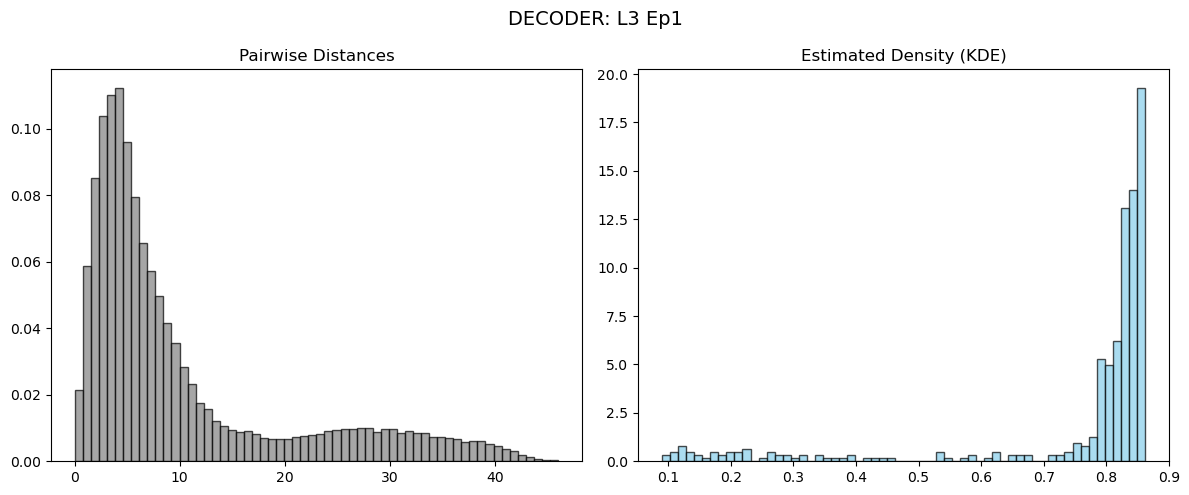

In [19]:
plot_kde_geometry(recorder=RecorderActivat, mi_estimator=mi_estimator, part="decoder", layer=3, epoch=1)

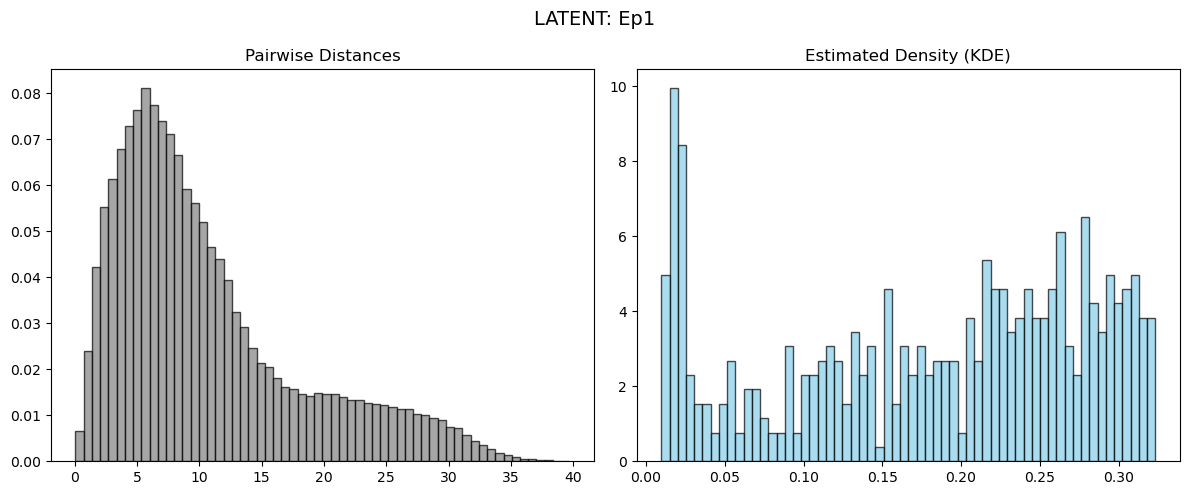

In [20]:
plot_kde_geometry(recorder=RecorderActivat, mi_estimator=mi_estimator, part="latent",epoch=1)

## Information Plane

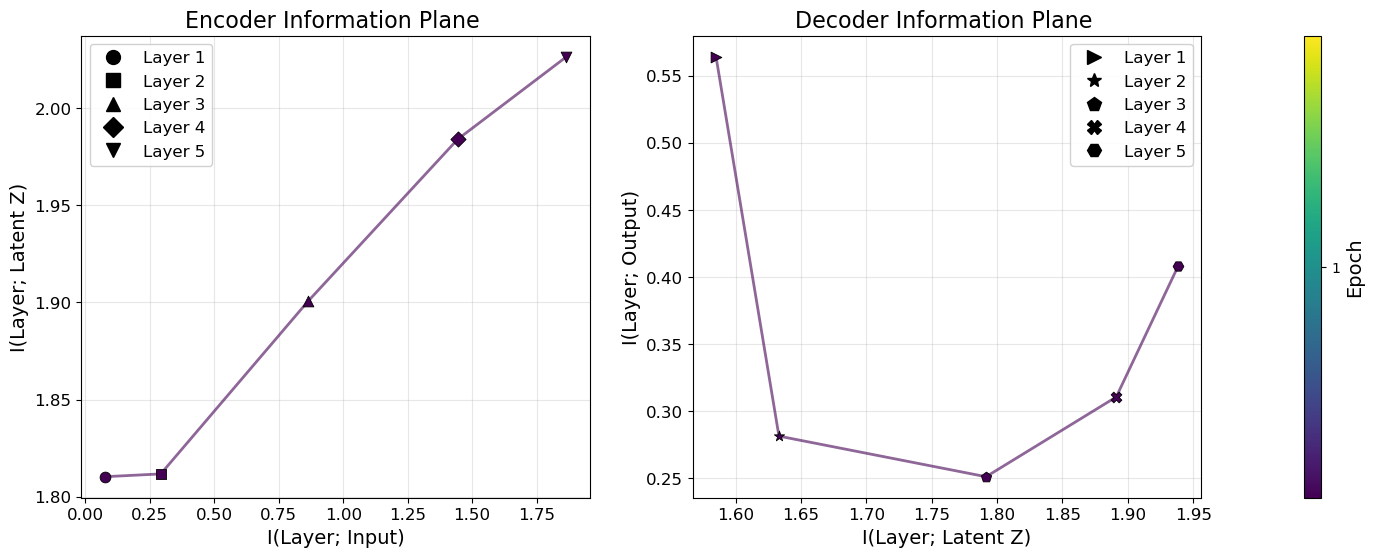

In [21]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=-1, Step=1)

In [ ]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=6, end_epoch=15, Step=1)

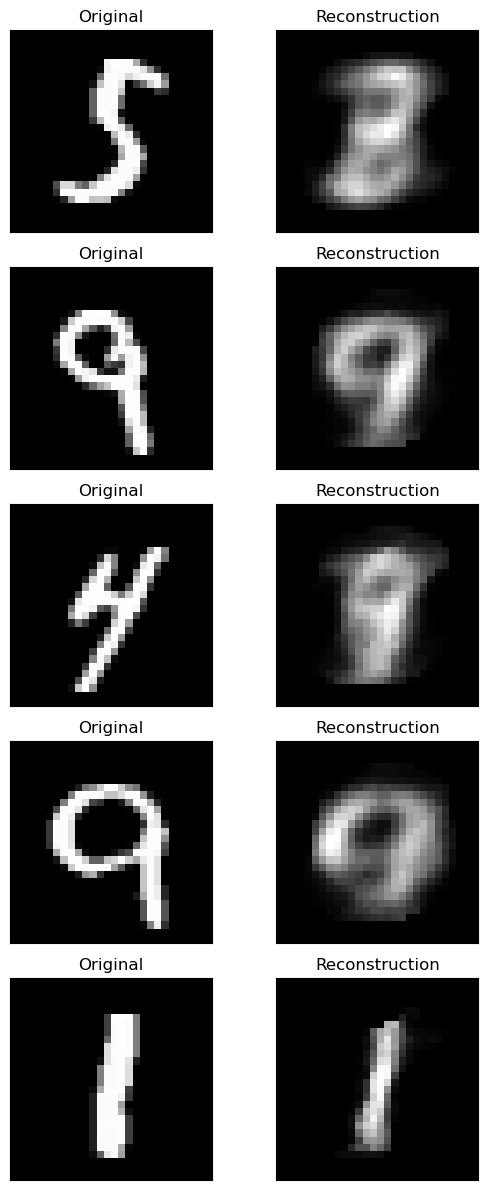

In [23]:
ShowSomeImages(model, testDataset, device)

--------
--------

# Studying $\tanh$ activation

In [ ]:
tanh_model = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[200, 150, 100, 50],
                               activation_enc=nn.Tanh,
                               activation_dec=nn.Tanh,
                               Variational = True
                              )

tanh_model.to(device)

In [ ]:
# same implementation as above
optimizer = torch.optim.Adam(tanh_model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

# global usefull elements
epochs = 6

method_mi="kde"
sigmaKDE = 2
n_neigKRASKOV = 3

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator( method=method_mi, sigma=sigmaKDE, n_neig=n_neigKRASKOV )

In [ ]:
#---------- TRAINING ------------
final_loss = Training(
    tanh_model,
    optimizer,
    loss_fn,
    num_epochs=epochs, 
    sampleMI=1000,
    mi_estimator=mi_estimator,
    showImage=False,
    doTest=False
)

In [ ]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=epochs, Step=1)

In [ ]:
ShowSomeImages(tanh_model, testDataset, device)

## Checking the SAXE paper about linearity and non-linearity

In [ ]:
modelReLU = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[300, 100, 50],
                               activation_enc=nn.ReLU,
                               activation_dec=nn.ReLU,
                               Variational = True
                              )

modelReLU.to(device)

optimizer = torch.optim.Adam(modelReLU.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

In [ ]:
epochs = 20

method_mi="kde"
sigmaKDE = 1

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator(method=method_mi, sigma=sigmaKDE)

finalLoss_ReLU, LatentMI_ReLU,LayerActivation  = Training(modelReLU, optimizer, loss_fn, num_epochs=epochs, sampleMI=500, mi_estimator=mi_estimator,)

In [ ]:
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=10, end_epoch=epochs, Step=1)

In [ ]:
AnimateActivations(LayerActivation, layer = 1)

In [ ]:
modelTanh = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[30, 20],
                               activation_enc=nn.Tanh,
                               activation_dec=nn.Tanh,
                               Variational = True
                              )

modelTanh.to(device)

optimizer = torch.optim.Adam(modelTanh.parameters(), lr=5e-5)
loss_fn = torch.nn.MSELoss()

In [ ]:
epochs = 25
method_mi="kde"


RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator(method=method_mi)

finalLoss_Tanh, LatentMI_Tanh, EpochsActiv = Training(modelTanh, optimizer, loss_fn, num_epochs=epochs, sampleMI=500, mi_estimator=mi_estimator,)

In [ ]:
plt.plot(LatentMI_Tanh)
plt.grid(True, alpha = 0.5)
plt.xlabel("Epochs")
plt.ylabel("Mutual information I(X:Z)")

In [ ]:
AnimateActivations(EpochsActiv, layer = 0)

In [ ]:
AnimateActivations(EpochsActiv, layer = 1)

In [ ]:
modelTanh2 = VariationalAutoEncoder(latentDim = 20,
                               hiddenDim=[300, 200, 100],
                               activation_enc=nn.Tanh,
                               activation_dec=nn.Tanh,
                               Variational = True
                              )

modelTanh2.to(device)

optimizer = torch.optim.Adam(modelTanh2.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

epochs = 80
method_mi="kde"


RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator(method=method_mi)

finalLoss_Tanh, LatentMI_Tanh2, EpochsActiv2 = Training(modelTanh2, optimizer, loss_fn, num_epochs=epochs, sampleMI=1000, mi_estimator=mi_estimator,)

In [ ]:
plt.plot(LatentMI_Tanh2)
plt.grid(True, alpha = 0.5)
plt.xlabel("Epochs")
plt.ylabel("Mutual information I(X:Z)")

In [ ]:
AnimateActivations(EpochsActiv2, layer = 0)

In [ ]:
AnimateActivations(EpochsActiv2, layer = 1)

In [ ]:
AnimateActivations(EpochsActiv2, layer = 2)

In [ ]:
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=epochs, Step=3)

## Changing architecture and latent space dimension

In [87]:
def GeneralTraining(model, optimizer, loss_fn, num_epochs, activation_rec: ActivationRecorder, mi_history: MI_History, mi_estimator, sampleMI, showImage=False, doTest=False):
    
    # Setting hooks
    activation_rec.InitialRegister(model)
    model.to(device)

    LatentMI = []
    LayerActivation = {f'Layer_{j}': [] for j in range(len(model.Encoder))}

    #------------Visualization of the activation of the weights
    #Takes a minibatch of images
    data_iter = iter(testDataloader)
    inputs, labels = next(data_iter)
    x = inputs.view(inputs.size(0), -1).to(device)
    
    h = x
    for j, layer in enumerate(model.Encoder):
        h = layer(h)
        # Save immediately
        LayerActivation[f'Layer_{j}'].append(h.detach().cpu().numpy().flatten())
   
   
    for epoch in tqdm(range(num_epochs)):
        model.train()
        losses = []
        clear_output(wait=True)
        
        for images, _ in (trainDataloader):#, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            targets = images.view(images.size(0), -1)
            
            outputs, z, mean, logVar = model(images)
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

        avg_train_loss = np.mean(losses)
        model.train_loss_history.append(avg_train_loss)
        
        # --- Validation Loop ---
        avg_val_loss = None
        if doTest:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for images, _ in testDataloader:
                    images = images.to(device)
                    targets = images.view(images.size(0), -1)
                    outputs, z = model(images)
                    loss = loss_fn(outputs, targets)
                    val_losses.append(loss.item())
            
            avg_val_loss = np.mean(val_losses)
            model.val_loss_history.append(avg_val_loss)

        # --- MI Calculation ---
        res = VAE_info(
            model, 
            trainDataset, 
            device, 
            epoch=epoch, 
            num_samples=sampleMI, 
            mi_estimator=mi_estimator, 
            RecorderActivat=activation_rec)
        mi_history.append(res)

        test = LatentVAE_Info(model, trainDataset, device, epoch=epoch, num_samples=sampleMI, mi_estimator=mi_estimator, RecorderActivat=activation_rec)
        LatentMI.append(test)


        #------------Visualization of the activation of the weights
        #Takes a minibatch of images
        data_iter = iter(testDataloader)
        inputs, labels = next(data_iter)
        x = inputs.view(inputs.size(0), -1).to(device)
        
        h = x
        for j, layer in enumerate(model.Encoder):
            h = layer(h)
            # Append to the existing list for this layer
            LayerActivation[f'Layer_{j}'].append(h.detach().cpu().numpy().flatten())
        
        # --- Print & Show ---
        val_str = f" — val: {avg_val_loss:.4f}" if avg_val_loss else ""
        print(f"Epoch {epoch+1} — train: {avg_train_loss:.4f}{val_str}")

        if showImage and (epoch % 5 == 0 or epoch == num_epochs - 1):
            model.eval()
            img = testDataset[0][0].unsqueeze(0).to(device)
            with torch.no_grad():
                recon = model(img)[0]
            
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img.cpu().squeeze(), cmap='gray')
            axs[0].set_title("Original")
            axs[1].imshow(recon.cpu().squeeze().view(28, 28), cmap='gray')
            axs[1].set_title("Recon")
            plt.show()
            plt.close()

    return np.mean(losses), LatentMI, LayerActivation

In [88]:
def TrainDifferentArchitectures(hidden_dimensions, latent_dimensions, epochs, lr=5e-4, file_name=""):
    '''
        Iterates the VAE training over a grid and saves the MI_history of each train in a dictionary.


        The grid is made by all the combinations (cartesian prod.) of hidden_dimensions (VAE architectures) and 
        latent_dimension (dimensions of the latent space). 
        If file_name is provided, it creates a file containing a list of MI_History objects.
    '''

    grid = product(hidden_dimensions, latent_dimensions)
    mi_histories = {}

    for h_dim, Z in grid:

        print(f"----- Training VAE with hidden space dim. {Z} and hidden layers dim. {h_dim} ------\n\n")

        model = VariationalAutoEncoder(
            latentDim=Z,
            hiddenDim=h_dim,
            activation_enc=nn.Tanh,
            activation_dec=nn.Tanh,
            Variational=True
        )

        model.to(device)

        # Training parameters
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.MSELoss()
        epochs = epochs
        method_mi="kde"
        sigmaKDE = 1

        # Instances for recording MI evolution
        activation_rec = ActivationRecorder()
        mi_history = MI_History()
        mi_estimator = MI_Estimator( method=method_mi, sigma=sigmaKDE)

        # Train and plot MI
        _, _, _ = GeneralTraining(
            model, 
            optimizer, 
            loss_fn, 
            num_epochs=epochs, 
            sampleMI=1000, 
            mi_history=mi_history,
            activation_rec=activation_rec,
            mi_estimator=mi_estimator
            )
        
        mi_history.show()
        mi_histories[str((h_dim, Z))] = mi_history

    if file_name != "":
        with open(file_name, "wb") as f:
            pickle.dump(mi_histories, f)
    else:
        return mi_histories

1) Fix VAE architecture and change latent space dimension

In [ ]:
hidden_dimensions = [[200, 100, 50]]
latent_dimensions = [10, 25, 50]
epochs = 50
#mi_histories = TrainDifferentArchitectures(hidden_dimensions, latent_dimensions, epochs=epochs, lr = 5e-4, file_name="Z:10_25_50")

100%|██████████| 50/50 [04:20<00:00,  5.20s/it]

Epoch 50 — train: 0.0084
==================== MI HISTORY (all) ====================
EPOCH 1
  [Global] I(Input, Z): 6.892 | I(Z, Output): 0.000
  [Encoder]
    Layer 1: I(Input, L)=1.315 | I(L, Z)=1.319
    Layer 2: I(Input, L)=0.043 | I(L, Z)=0.043
    Layer 3: I(Input, L)=0.001 | I(L, Z)=0.001
  [Decoder]
    Layer 1: I(Z, L)=0.627     | I(L, Output)=0.000
    Layer 2: I(Z, L)=0.097     | I(L, Output)=0.000
    Layer 3: I(Z, L)=0.004     | I(L, Output)=-0.000
--------------------------------------------------
EPOCH 2
  [Global] I(Input, Z): 6.895 | I(Z, Output): 0.000
  [Encoder]
    Layer 1: I(Input, L)=1.277 | I(L, Z)=1.280
    Layer 2: I(Input, L)=0.037 | I(L, Z)=0.038
    Layer 3: I(Input, L)=0.001 | I(L, Z)=0.001
  [Decoder]
    Layer 1: I(Z, L)=0.716     | I(L, Output)=0.000
    Layer 2: I(Z, L)=0.120     | I(L, Output)=0.000
    Layer 3: I(Z, L)=0.006     | I(L, Output)=-0.000
--------------------------------------------------
EPOCH 3
  [Global] I(Input, Z): 6.892 | I(Z, Outpu

([200, 100, 50], 10)
([200, 100, 50], 25)
([200, 100, 50], 50)


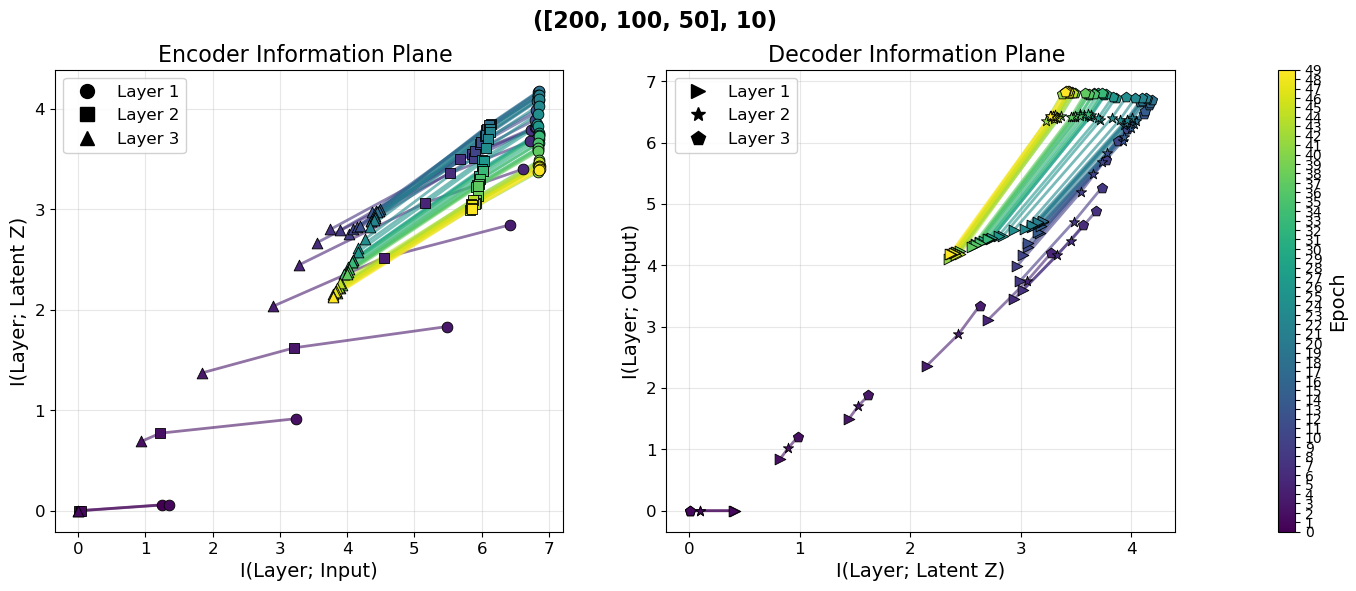

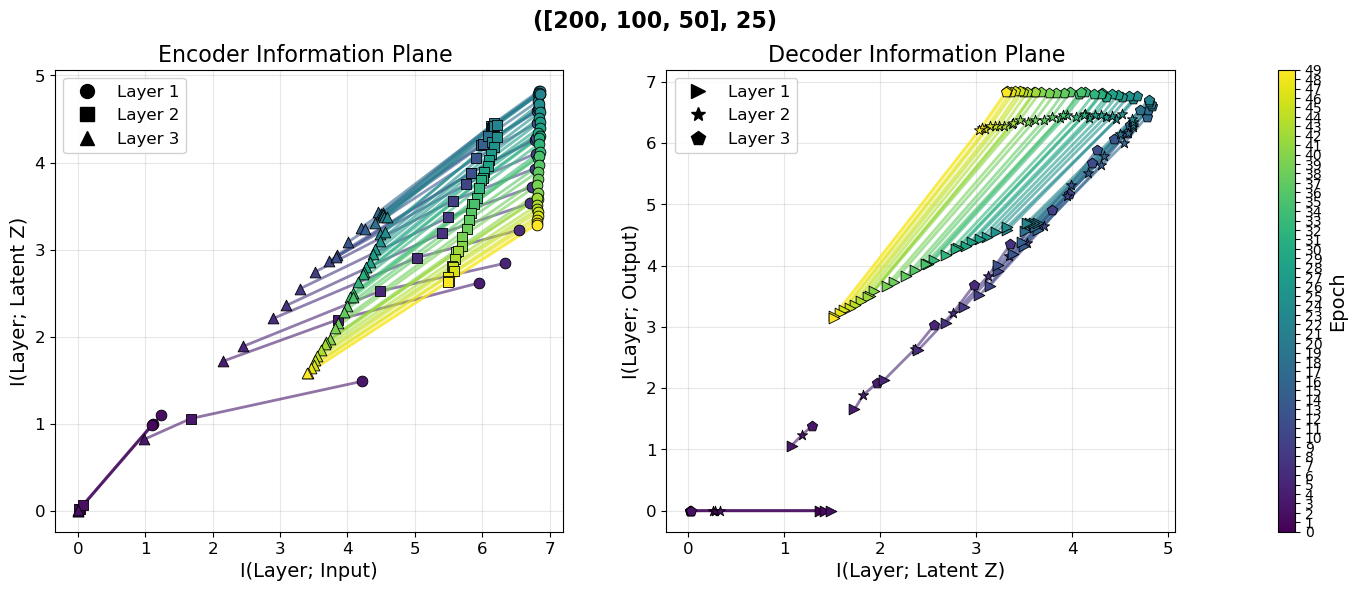

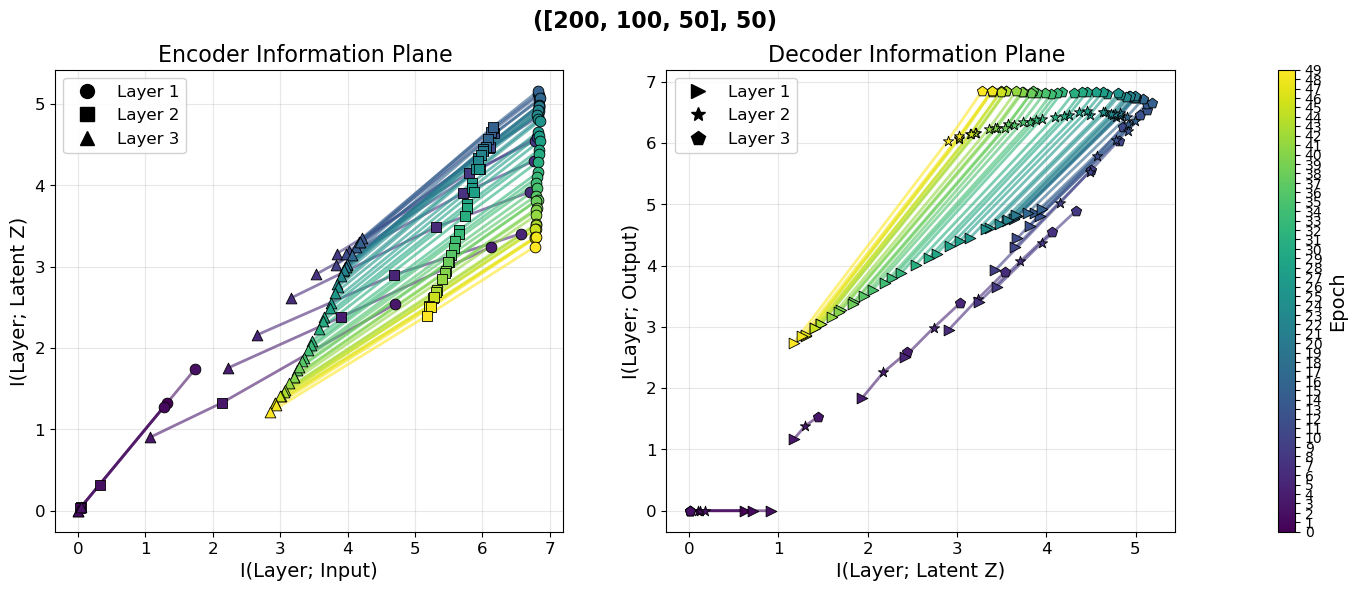

In [111]:
mi_histories = read_MI_hist("Z:10_25_50")
for combination, mi_history in mi_histories.items():
    print(combination)
    PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=0, end_epoch=epochs, Step=1, suptitle=combination)

In [121]:
hidden_dimensions = [[200, 100, 50], [300, 200, 100, 50], [400, 300, 200, 100, 50]]
latent_dimensions = [25]
epochs = 50
file_name = "HL:" + ",".join([f"{hd}" for hd in hidden_dimensions])
mi_histories = TrainDifferentArchitectures(hidden_dimensions, latent_dimensions, epochs=epochs, lr = 5e-4, file_name=file_name)

100%|██████████| 50/50 [05:41<00:00,  6.83s/it]

Epoch 50 — train: 0.0304
==================== MI HISTORY (all) ====================
EPOCH 1
  [Global] I(Input, Z): 6.868 | I(Z, Output): 0.000
  [Encoder]
    Layer 1: I(Input, L)=3.036 | I(L, Z)=3.023
    Layer 2: I(Input, L)=0.210 | I(L, Z)=0.209
    Layer 3: I(Input, L)=0.003 | I(L, Z)=0.003
    Layer 4: I(Input, L)=0.000 | I(L, Z)=0.000
    Layer 5: I(Input, L)=-0.000 | I(L, Z)=0.000
  [Decoder]
    Layer 1: I(Z, L)=3.937     | I(L, Output)=0.000
    Layer 2: I(Z, L)=1.864     | I(L, Output)=0.000
    Layer 3: I(Z, L)=0.829     | I(L, Output)=0.000
    Layer 4: I(Z, L)=0.152     | I(L, Output)=0.000
    Layer 5: I(Z, L)=0.005     | I(L, Output)=0.000
--------------------------------------------------
EPOCH 2
  [Global] I(Input, Z): 6.881 | I(Z, Output): 0.000
  [Encoder]
    Layer 1: I(Input, L)=3.009 | I(L, Z)=3.007
    Layer 2: I(Input, L)=0.166 | I(L, Z)=0.166
    Layer 3: I(Input, L)=0.006 | I(L, Z)=0.006
    Layer 4: I(Input, L)=0.000 | I(L, Z)=0.000
    Layer 5: I(Input, L)=

([200, 100, 50], 25)
([300, 200, 100, 50], 25)
([400, 300, 200, 100, 50], 25)


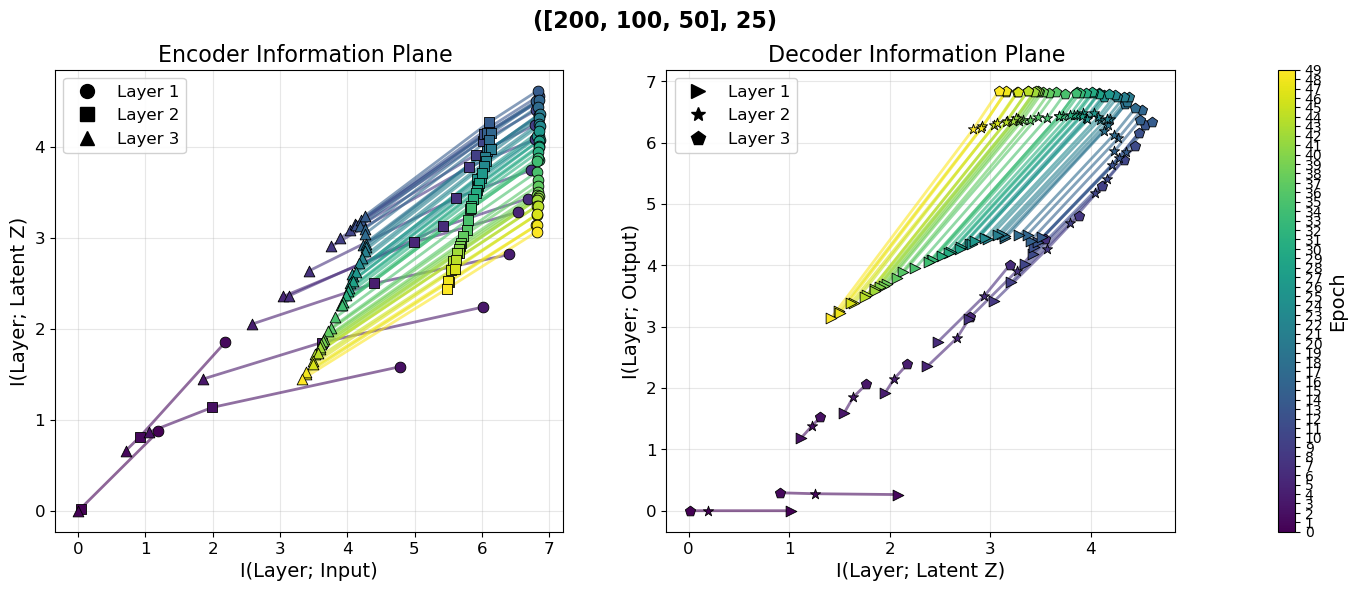

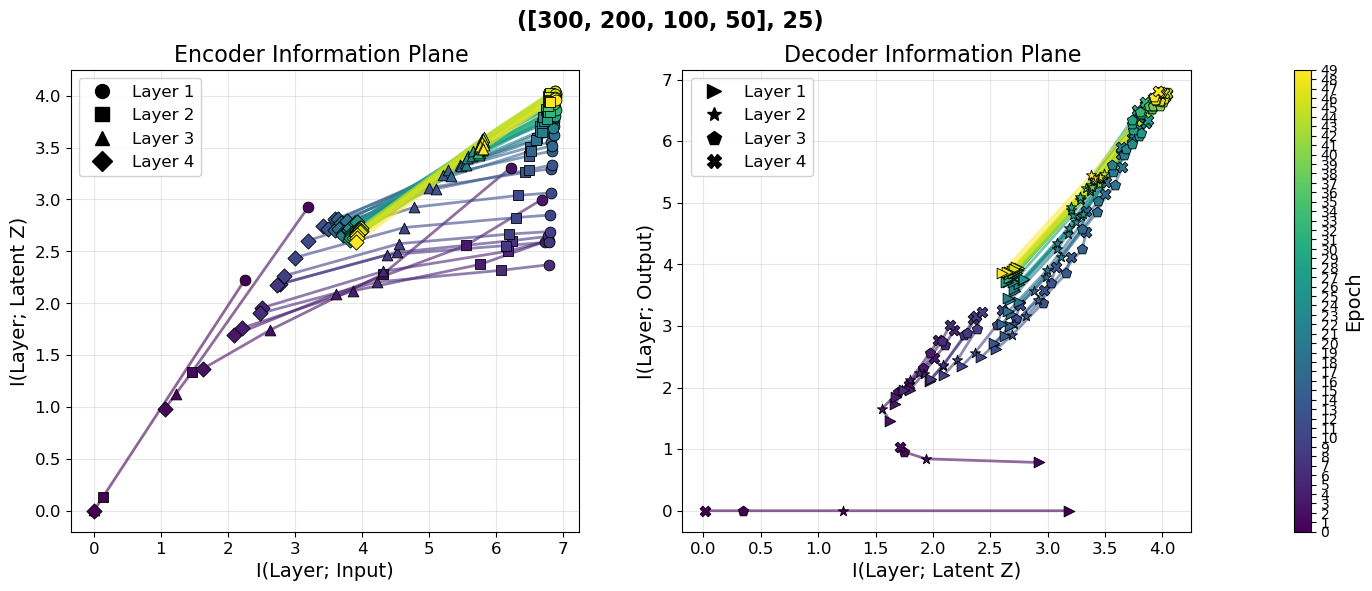

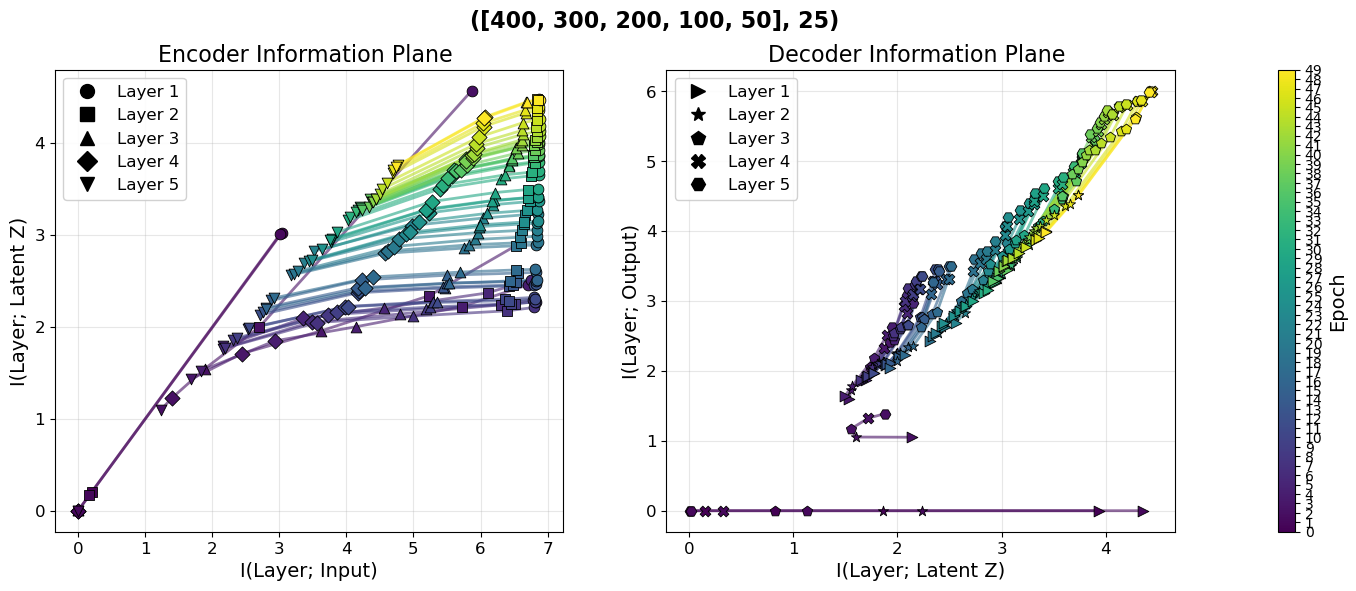

In [122]:
mi_histories = read_MI_hist(file_name)
for combination, mi_history in mi_histories.items():
    print(combination)
    PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=0, end_epoch=epochs, Step=1, suptitle=combination)

--------
--------

--------
--------

--------
--------

# Parte Nicolò

In [ ]:
# --- Noise functions ---
def gaussian_noise(z: torch.Tensor, std: float) -> torch.Tensor:

    noise = torch.randn_like(z) * std
    noisy_z = z + noise
    return noisy_z

def bitflip_noise(z: torch.Tensor, p: float) -> torch.Tensor:
    flip_mask = torch.rand_like(z) < p
    noisy_z = z.clone()
    noisy_z[flip_mask] = -noisy_z[flip_mask]
    return noisy_z

def deactivate_input_noise(z: torch.Tensor, p: float) -> torch.Tensor:
    deactivate_mask = torch.rand_like(z) < p
    noisy_z = z.clone()
    noisy_z[deactivate_mask] = 0.0
    return noisy_z

In [ ]:
DEBUG = True

def visualize_random_reconstruction(
    model,
    dataset,
    device: str = "cpu",
    noise_function=gaussian_noise,
    params=[0.5],
    renormalisation = False
):
    """
    Plots:
    1) Original image
    2) Reconstruction
    3) Reconstruction from noisy latent vector
    4) Original image with corresponding decoded latent noise added
    """

    model.eval()
    model.to(device)

    # ---------------- RANDOM SAMPLE ----------------
    idx = np.random.randint(0, len(dataset))
    x = dataset[idx]

    #print the max and min of the image
    

    # Handle datasets returning (image, label)
    if isinstance(x, (tuple, list)):
        x = x[0]

    x = x.to(device)
    x_batch = x.unsqueeze(0)

    with torch.no_grad():
        # ---------------- ENCODE ----------------
        z, _, _ = model.Encoding(x_batch)

        # ---------------- STANDARD RECONSTRUCTION ----------------
        x_rec = model.Decoding(z)

        # ---------------- NOISY LATENT RECONSTRUCTION ----------------
        if renormalisation:
            # normalize z to be between 0 and 1
            z_renorm = z / torch.max(z)
            z_noisy = noise_function(z_renorm, *params)
            # renormalize back
            z_noisy = z_noisy * torch.max(z)

        else:
            z_noisy = noise_function(z, *params)

        if DEBUG:
            print(f"Max z: {torch.max(z).item():.4f}, Min z: {torch.min(z).item():.4f}")
            print(f"Max z_noisy: {torch.max(z_noisy).item():.4f}, Min z_noisy: {torch.min(z_noisy).item():.4f}")
            print(f"Original z: {z}")
            print(f"Noisy z: {z_noisy}")
        
        x_noisy = model.Decoding(z_noisy)

        # ---------------- DECODED NOISE (INPUT-SPACE EFFECT) ----------------
        x_input_noisy = noise_function(x, *params)

    # ---------------- RESHAPE FOR PLOTTING ----------------
    def reshape(img):
        img = img.squeeze().cpu().numpy()
        side = int(np.sqrt(img.size))
        return img.reshape(side, side)

    x_np = reshape(x)
    x_rec_np = reshape(x_rec)
    x_noisy_np = reshape(x_noisy)
    x_input_noisy_np = reshape(x_input_noisy)

    # ---------------- PLOT ----------------
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(x_np, cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(x_rec_np, cmap="gray")
    axes[1].set_title("Reconstruction")
    axes[1].axis("off")

    axes[2].imshow(x_noisy_np, cmap="gray")
    axes[2].set_title("Latent + Noise")
    axes[2].axis("off")

    axes[3].imshow(x_input_noisy_np, cmap="gray")
    axes[3].set_title("Original + Decoded Latent Noise")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


Max z: 8.2561, Min z: -5.0589
Max z_noisy: 7.8937, Min z_noisy: -5.7619
Original z: tensor([[-1.4701, -1.2989, -1.4227,  8.2561, -2.1337, -5.0589, -2.8675,  1.7098,
          1.0329, -1.4672]], device='mps:0')
Noisy z: tensor([[-1.5797, -1.8474, -1.8793,  7.8937, -1.1576, -5.7619, -2.8397,  2.1678,
          0.4095, -0.9513]], device='mps:0')


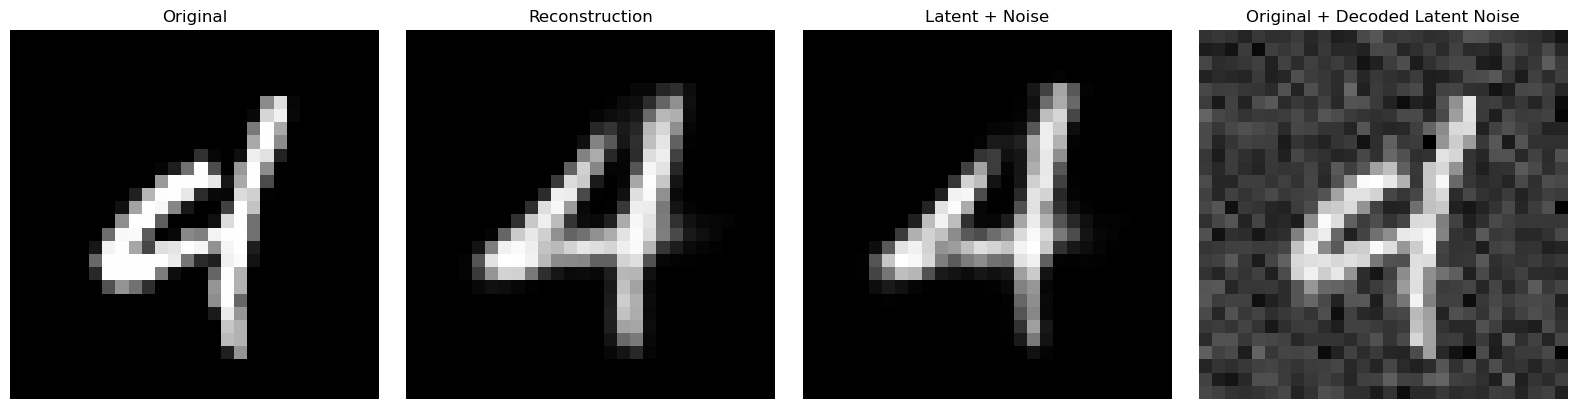

In [ ]:
random_number = 42
np.random.seed(random_number)

visualize_random_reconstruction(
    model=model,
    dataset=trainDataset,
    device=device,
    noise_function=gaussian_noise,
    params = [0.1],
    renormalisation = True
    )

Max z: 8.2561, Min z: -5.0589
Max z_noisy: 8.2561, Min z_noisy: -5.0589
Original z: tensor([[-1.4701, -1.2989, -1.4227,  8.2561, -2.1337, -5.0589, -2.8675,  1.7098,
          1.0329, -1.4672]], device='mps:0')
Noisy z: tensor([[ 1.4701, -1.2989, -1.4227,  8.2561, -2.1337, -5.0589, -2.8675,  1.7098,
          1.0329, -1.4672]], device='mps:0')


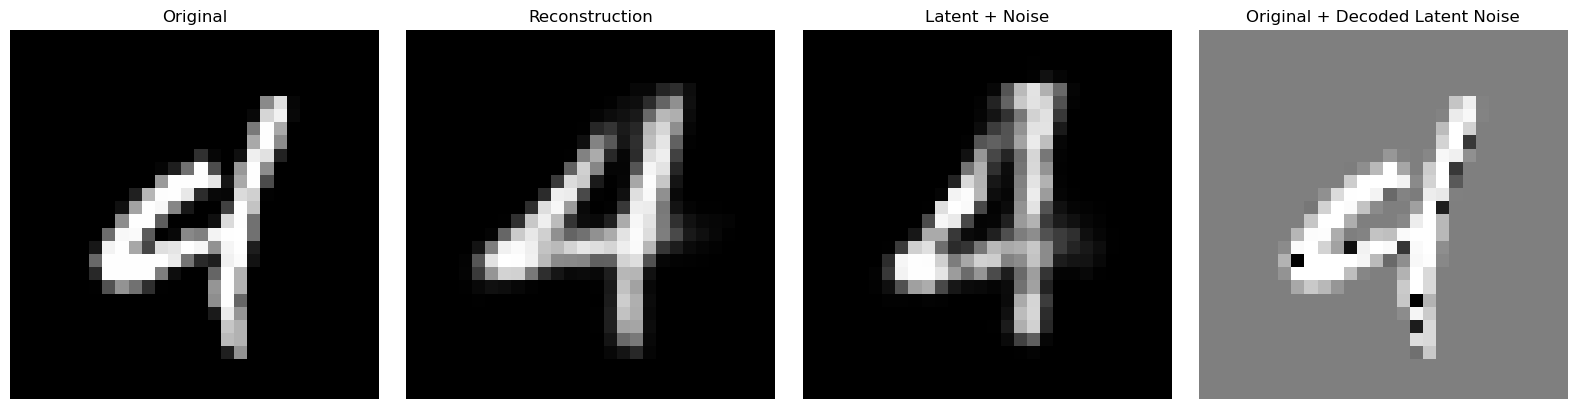

In [ ]:
np.random.seed(random_number)

visualize_random_reconstruction(
    model=model,
    dataset=trainDataset,
    device=device,
    noise_function=bitflip_noise,
    params = [0.1],
    renormalisation = True
    )

Max z: 8.2561, Min z: -5.0589
Max z_noisy: 1.7098, Min z_noisy: -1.4701
Original z: tensor([[-1.4701, -1.2989, -1.4227,  8.2561, -2.1337, -5.0589, -2.8675,  1.7098,
          1.0329, -1.4672]], device='mps:0')
Noisy z: tensor([[-1.4701, -1.2989,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.7098,
          1.0329, -1.4672]], device='mps:0')


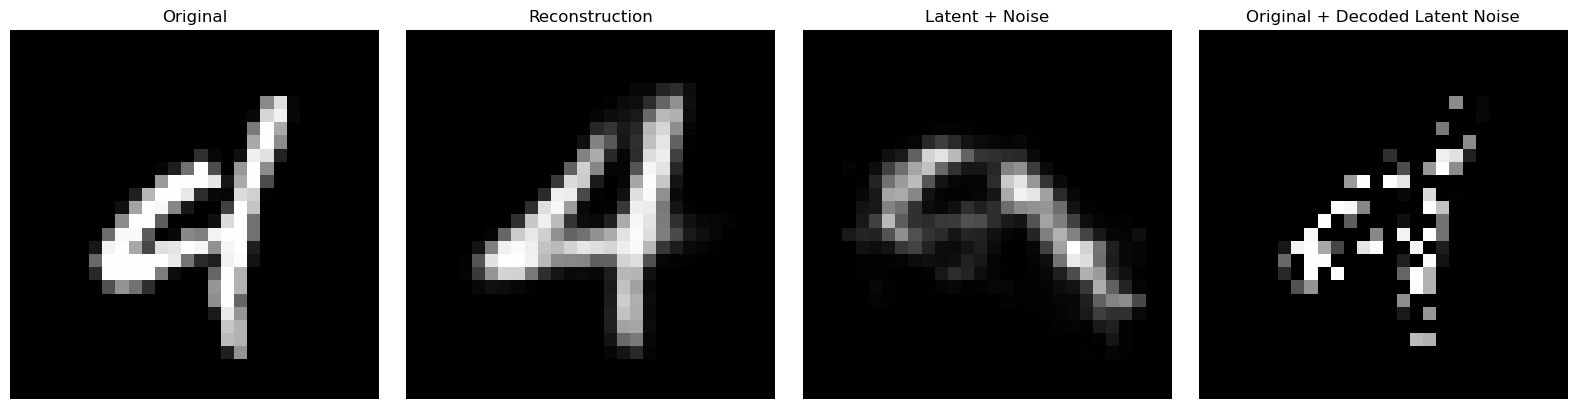

In [ ]:
np.random.seed(random_number)

visualize_random_reconstruction(
    model=model,
    dataset=trainDataset,
    device=device,
    noise_function=deactivate_input_noise,
    params = [0.5],
    renormalisation = True
    )

/var/folders/6w/vv6mxd6s5tn2fg5xf8lytbl40000gp/T/ipykernel_23279/517001327.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([latent_mse_list, direct_mse_list],


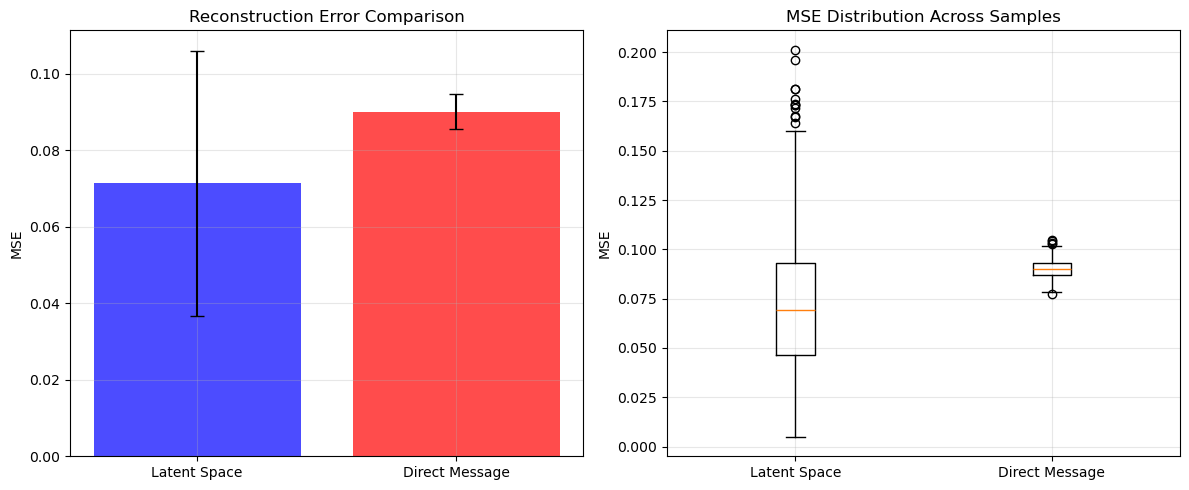


=== Channel Performance Comparison ===
Latent Space Transmission:
  Average MSE: 0.071348 ± 0.034695

Direct Message Transmission:
  Average MSE: 0.090085 ± 0.004546

Improvement: 20.80%


{'latent_mse': np.float64(0.07134815503563732),
 'direct_mse': np.float64(0.0900852403268218),
 'latent_std': np.float64(0.034694752216289065),
 'direct_std': np.float64(0.004545694520572532),
 'latent_samples': [0.09924491494894028,
  0.04965188726782799,
  0.0591205395758152,
  0.06888192892074585,
  0.07662301510572433,
  0.032752759754657745,
  0.09680283069610596,
  0.060775261372327805,
  0.0634249895811081,
  0.06486639380455017,
  0.06664036214351654,
  0.09322065860033035,
  0.05755337327718735,
  0.09812510758638382,
  0.08377071470022202,
  0.0601528137922287,
  0.054026685655117035,
  0.02059357799589634,
  0.03634246438741684,
  0.14103074371814728,
  0.13644550740718842,
  0.08840328454971313,
  0.11115575581789017,
  0.10558141767978668,
  0.044273361563682556,
  0.14245003461837769,
  0.06598291546106339,
  0.057633038610219955,
  0.030141057446599007,
  0.016904188320040703,
  0.06930480897426605,
  0.1371290385723114,
  0.06455694139003754,
  0.034083060920238495,
  0

In [ ]:
def compare_channel_performance(
    model,
    dataset,
    device: str = "cpu",
    noise_function=gaussian_noise,
    params=[0.5],
    num_samples: int = 100,
    renormalisation: bool = True
):
    """
    Compare VAE latent space transmission vs direct message transmission through a noisy channel.
    
    Returns:
        - MSE for latent space transmission
        - MSE for direct message transmission
        - SSIM scores for both
    """
    model.eval()
    model.to(device)
    
    latent_mse_list = []
    direct_mse_list = []
    latent_ssim_list = []
    direct_ssim_list = []
    
    for _ in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        x = dataset[idx]
        
        if isinstance(x, (tuple, list)):
            x = x[0]
        
        x = x.to(device)
        x_batch = x.unsqueeze(0)
        
        with torch.no_grad():
            # ---- LATENT SPACE TRANSMISSION ----
            z, _, _ = model.Encoding(x_batch)
            
            if renormalisation:
                z_renorm = z / (torch.max(z) + 1e-8)
                z_noisy = noise_function(z_renorm, *params)
                z_noisy = z_noisy * torch.max(z)
            else:
                z_noisy = noise_function(z, *params)
            
            x_latent_transmitted = model.Decoding(z_noisy)
            
            # ---- DIRECT MESSAGE TRANSMISSION ----
            x_noisy = noise_function(x, *params)
            
            # ---- COMPUTE METRICS ----
            x_flat = x.view(-1)
            x_latent_flat = x_latent_transmitted.squeeze().view(-1)
            x_direct_flat = x_noisy.view(-1)
            
            latent_mse = torch.mean((x_flat - x_latent_flat) ** 2).item()
            direct_mse = torch.mean((x_flat - x_direct_flat) ** 2).item()
            
            latent_mse_list.append(latent_mse)
            direct_mse_list.append(direct_mse)
    
    avg_latent_mse = np.mean(latent_mse_list)
    avg_direct_mse = np.mean(direct_mse_list)
    std_latent_mse = np.std(latent_mse_list)
    std_direct_mse = np.std(direct_mse_list)
    
    # ---- VISUALIZATION ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].bar(['Latent Space', 'Direct Message'], 
                [avg_latent_mse, avg_direct_mse],
                yerr=[std_latent_mse, std_direct_mse],
                capsize=5, alpha=0.7, color=['blue', 'red'])
    axes[0].set_ylabel('MSE')
    axes[0].set_title('Reconstruction Error Comparison')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].boxplot([latent_mse_list, direct_mse_list], 
                     labels=['Latent Space', 'Direct Message'])
    axes[1].set_ylabel('MSE')
    axes[1].set_title('MSE Distribution Across Samples')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== Channel Performance Comparison ===")
    print(f"Latent Space Transmission:")
    print(f"  Average MSE: {avg_latent_mse:.6f} ± {std_latent_mse:.6f}")
    print(f"\nDirect Message Transmission:")
    print(f"  Average MSE: {avg_direct_mse:.6f} ± {std_direct_mse:.6f}")
    print(f"\nImprovement: {((avg_direct_mse - avg_latent_mse) / avg_direct_mse * 100):.2f}%")
    
    return {
        'latent_mse': avg_latent_mse,
        'direct_mse': avg_direct_mse,
        'latent_std': std_latent_mse,
        'direct_std': std_direct_mse,
        'latent_samples': latent_mse_list,
        'direct_samples': direct_mse_list
    }

compare_channel_performance(
    model=model,
    dataset=trainDataset,
    device=device,
    noise_function=gaussian_noise,
    params = [0.3],
    renormalisation = True,
    num_samples = 1000
    )

# Francesco ridurre info dei float

In [28]:
import torch.nn.utils.parametrize as parametrize


class BitwiseWeightQuantizer(nn.Module):
    def __init__(self, nBits=8):
        super().__init__()
        self.nBits = nBits

        # The range of a signed n-bit integer is [-(2^(n-1)), 2^(n-1) - 1]
        self.q_min = -(2 ** (nBits - 1))
        self.q_max = (2 ** (nBits - 1)) - 1

    def forward(self, w):

        #Determine the scale factor
        maxVal = w.abs().max()
        # Avoid division by zero
        maxVal = torch.max(maxVal, torch.tensor(1e-8, device=w.device))
        
        scale = maxVal / self.q_max
        
        #Quantize: divide by scale, round to nearest integer, clip to bit range
        wInt = torch.round(w / scale)
        wInt = torch.clamp(wInt, self.q_min, self.q_max)
        
        #Dequantize: multiply back by scale to get "fake quantized" float values
        w_quant = wInt * scale
        
        #Straight-Through Estimator:
        #Gradients flow through unmodified (w), but values are quantized (w_quant)
        return w + (w_quant - w).detach()

def ApplyBitwiseQuantization(model, nBits=4):
    print(f"--- Applying Bitwise Quantization ({nBits}-bit) ---")
    count = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # Replaces the 'weight' parameter with the quantized version
            parametrize.register_parametrization(module, "weight", BitwiseWeightQuantizer(nBits))
            count += 1
    print(f"Quantization applied to {count} Linear layers.\n")



# Initialize your model
model2 = VariationalAutoEncoder(latentDim=10, hiddenDim=[100, 50, 20], activation_enc=nn.Tanh, activation_dec=nn.Tanh, Variational=True)

ApplyBitwiseQuantization(model2, nBits=4)

# Move to device
model2.to(device)


print("Checking weights of the first layer to verify quantization:")
first_layer_weights = model2.Encoder[0][0].weight
print(first_layer_weights[0][:10]) 


optimizer = torch.optim.Adam(model2.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

method_mi="kde"
sigmaKDE = 0.5
epochs = 40

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator(method=method_mi, sigma=sigmaKDE)

finalLoss_Tanh, LatentMI_Tanh2, EpochsActiv2 = Training(model2, optimizer, loss_fn, num_epochs=epochs, sampleMI=1000, mi_estimator=mi_estimator,)
#PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=epochs, Step=1)

100%|██████████| 40/40 [03:19<00:00,  4.98s/it]

Epoch 40 — train: 0.0549


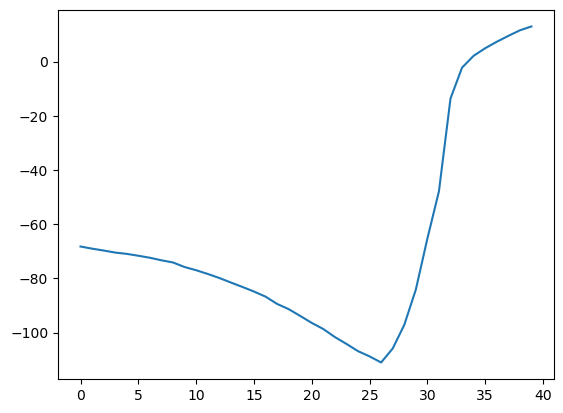

In [29]:
plt.plot(LatentMI_Tanh2)

In [30]:
# Initialize your model
model3 = VariationalAutoEncoder(latentDim=10, hiddenDim=[100, 50, 20], activation_enc=nn.Tanh, activation_dec=nn.Tanh, Variational=True)

ApplyBitwiseQuantization(model3, nBits=32)

# Move to device
model3.to(device)


print("Checking weights of the first layer to verify quantization:")
first_layer_weights = model3.Encoder[0][0].weight
print(first_layer_weights[0][:10]) 


optimizer = torch.optim.Adam(model3.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

method_mi="kde"
sigmaKDE = 0.5
epochs = 60

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator3 = MI_Estimator(method=method_mi, sigma=sigmaKDE)

finalLoss_Tanh, LatentMI_Tanh2, EpochsActiv2 = Training(model3, optimizer, loss_fn, num_epochs=epochs, sampleMI=1000, mi_estimator=mi_estimator3,)
#PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=epochs, Step=1)

100%|██████████| 60/60 [04:56<00:00,  4.94s/it]

Epoch 60 — train: 0.0393


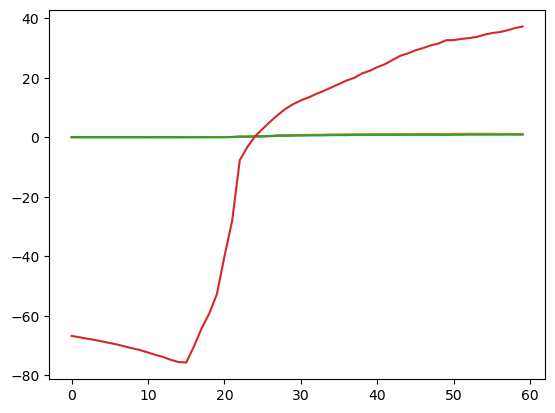

In [31]:
plt.plot([mi_history.encoder[i][0][0] for i in range(epochs)])
plt.plot([mi_history.encoder[i][1][0] for i in range(epochs)])
plt.plot([mi_history.encoder[i][2][0] for i in range(epochs)])

plt.plot(LatentMI_Tanh2)

--------
--------

--------
--------